# Status + LTD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import lines
import pandas as pd
import scipy.special
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
outputs_dir_test = Path("../../outputs/LtdStatus/outputs/test2")
# outputs_dir = Path("../../outputs/LtdStatus/outputs/anal")
# outputs_dir_new = Path("../../outputs/LtdStatus/outputs/n100")
# outputs_dir_sepa = Path("../../outputs/LtdStatus/outputs/sepa_0_2")
outputs_dir_triads_slash = Path("../../outputs/LtdReal/outputs/slash-s400-triads")
outputs_dir_triads_slash1000 = Path("../../outputs/LtdReal/outputs/slash-s1000-triads")
outputs_dir_triads_wiki = Path("../../outputs/LtdReal/outputs/wiki-s400-triads")
outputs_dir_triads_wiki1000 = Path("../../outputs/LtdReal/outputs/wiki-s1000-triads")
# outputs_dir_triads_long = Path("../../outputs/LtdStatus/outputs/triads_distr_long")
# outputs_dir_triads_n100 = Path("../../outputs/LtdStatus/outputs/triads_distr_n100")
outputs_dir_triads_wiki2 = Path("../../outputs/LtdReal/outputs/wiki2-s400-triads")
outputs_dir_triads_wiki2_1000 = Path("../../outputs/LtdReal/outputs/wiki2-s1000-triads")

# Phase transition details

In [3]:
"""These functions present analytical solutions for the model. 
The parameter `label` can be one of the two values: Adam or Piotr. 
When it is Adam the `q` parameter is as it is in the paper, that is
it is the probability of the status dynamics. 
"""


def get_pb_crit(q, ph, label="adam"):
    """
    This function doesn't check if critical value exists. One needs to check beforehand. 
    """
    if label == "adam":
        q = 1-q
    return ((2*q + (1-q)*(1-2*ph))**2 / (8*q**2) + 1)/2

def get_rho_crit(q,ph, label="adam"):
    """
    This function doesn't check if critical value exists. One needs to check beforehand. 
    Basic assumption: pb_crit>0.5
    """
    if label == "adam":
        q = 1-q
    return 2*q/(2*q + (1-q)*(1-2*ph))

def get_pb_when_rho_eq_1(q, ph, label="adam"):
    """This function doesn't check if such pb exists. 

    Args:
        q (_type_): _description_
        ph (_type_): _description_
        label (str, optional): _description_. Defaults to "adam".
    """
    if label == "adam":
        q = 1-q
    return (3*q + (1-2*ph)*(1-q)) / (4*q)

def Delta(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return (2 *q + (1 -q)*(1 -2 *ph))** 2 - 4*(4 *pb *q -2 *q) *q

def afun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return (4 *pb *q -2 *q)
def bfun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return -2 *q - (1 -q)*(1 -2 *ph)
def cfun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return q

def get_rhos(pb,ph,q, label="adam"):
    a = afun(pb, ph, q, label=label)
    b = bfun(pb, ph, q, label=label)
    c = cfun(pb, ph, q, label=label)
    
    if a == 0:
        return (-c / b, )
    
    d = Delta(pb, ph, q, label=label)
    if d < 0:
        if np.round(d, decimals = 15) < 0:
            return (np.nan, )
        else:
            d = np.round(d, decimals = 15)
    
    rho1 = (-b  - np.sqrt(d)) / 2 /a
    rho2 = (-b  + np.sqrt(d)) / 2 /a
    return sorted([rho1, rho2])
# rho2(pb,ph,q) = (2q + (1-q)(1-2ph) + sqrt(Delta(pb,ph,q))) / 2*(4pb*q-2q)

def get_quasi_rho(pb,ph,q, label="adam"):
    """Returns one value which is the level of quasi-stationary state if such a level exists. 
    Otherwise returns np.NaN

    Args:
        pb (_type_): _description_
        ph (_type_): _description_
        q (_type_): _description_
    """
    rhos = get_rhos(pb,ph,q, label=label)
    
    if len(rhos) == 1:
        if np.isnan(rhos[0]):
            return np.NaN
        elif (rhos[0] <= 1) & (rhos[0] >= 0):
            return rhos[0]
        else:
            return np.NaN
    
    if (rhos[0] <= 1) & (rhos[0] >= 0):
        if rhos[0] < rhos[1]: #rhos[0] is in proper range and is smaller. 
            rho_exp = rhos[0]
        elif (rhos[1] <= 1) & (rhos[1] >= 0): #rhos[1] is in proper range and is smaller. 
            rho_exp = rhos[1]
        else: #rhos[0] is in proper range and rhos[1] is not. 
            rho_exp = rhos[0]
    elif (rhos[1] <= 1) & (rhos[1] >= 0): #rhos[1] is in proper range and rhos[0] is not. 
        rho_exp = rhos[1]
    else:
        rho_exp = np.NaN
        
    return rho_exp

def get_separatrix(pbs, ph, q, label="adam"):
    """Returns rho values of separatrix (if exists) for given parameters

    Args:
        pbs (list or numpy.array): pb values
        ph (float): probabiilty ph
        q (float): probability q
    """
    
    rho_crits = np.zeros(len(pbs))
    for i, pb in enumerate(pbs):
        rhos_crit = get_rhos(pb, ph, q, label=label)
        
        no_sep_value = True
        if len(rhos_crit) == 2:
            if 0 < rhos_crit[0] < 1:
                if 0 < rhos_crit[1] < 1:
                    no_sep_value = False
                    rho_crits[i] = rhos_crit[1]
        if no_sep_value:
            rho_crits[i] = np.nan
    return rho_crits

def get_quasi_q(rho, pb, ps):
    """Returns value of q in the quasi-stationary state. 

    Args:
        rho (_type_): _description_
        pb (_type_): _description_
        ps (_type_): _description_
    """
    val = 2*(2*pb - 1)*rho**2 - 2*rho+1
    return val/(val + (1-2*ps)*rho)

def get_quasi_pb(rho, ps, q):
    """Returns value of pb in the quasi-stationary state. 

    Args:
        rho (_type_): _description_
        pb (_type_): _description_
        ps (_type_): _description_
    """
    return 1/2 * (((2*(1-q) + (1-2*ps)*q)*rho - (1-q)) / (2*(1-q)*rho**2) + 1)

def get_quasi_ps(rho, pb, q):
    """Returns value of ps in the quasi-stationary state. 

    Args:
        rho (_type_): _description_
        pb (_type_): _description_
        ps (_type_): _description_
    """
    return 1/2 * ((1-q)/q * (2*rho - 2*(2*pb-1)*rho**2 - 1)/rho + 1)



def find_parameters(rho = -1., q = -1., ps = -1., pb = -1.):
    """The user should specify 3 parameters. The value of the 4th one will be returned. 
    The forth parameter will be such that the system will be in quasi-stationary state. 

    Args:
        rho (_type_, optional): _description_. Defaults to -1..
        q (_type_, optional): _description_. Defaults to -1..
        ps (_type_, optional): _description_. Defaults to -1..
        pb (_type_, optional): _description_. Defaults to -1..
    """
    pars = np.array([rho, q, ps, pb])
    count_m1 = sum(pars == -1)
    if count_m1 != 1:
        # print(pars)
        raise ValueError("One should define exactly 3 parameters. ", pars)
    if rho == -1.:
        return get_quasi_rho(pb,ps,q)
    elif q == -1.:
        return get_quasi_q(rho, pb,ps)
    elif ps == -1.:
        return get_quasi_ps(rho, pb,q)
    elif pb == -1.:
        return get_quasi_pb(rho,ps,q)
        
""" Let us test above functions
"""
qh = 0.5
psh = 0.7
pbh = 0.5
rhoh = find_parameters(q = qh, ps = psh, pb=pbh)

qh2 = find_parameters(rho = rhoh, ps = psh, pb=pbh)
psh2 = find_parameters(rho = rhoh, q = qh, pb=pbh)
pbh2 = find_parameters(rho = rhoh, ps = psh, q=qh)
assert(abs(qh2 - qh) < 1e-5)
assert(abs(psh2 - psh) < 1e-5)
assert(abs(pbh2 - pbh) < 1e-5)

## Process data

In [4]:
import os, ast

def process_data(data, n_links, n_triads, k=1):
    for column in data.columns[k:-2]:
        data.loc[:, column] = data[column].str.split(',').map(lambda x: [int(float(x_el))/n_triads for x_el in x])
    data.loc[:, 'rho'] = data['rho'].str.split(',').map(lambda x: [int(float(x_el))/n_links for x_el in x])
    return data

def means_of_data(data, start, steps):
    df = pd.DataFrame(columns=data.columns)
    for _, row in data.iterrows():
        df = df.append(pd.DataFrame({
        'prob': row.p,
        'rho': row.rho[start:][::steps],
        'n0': row.n0[start:][::steps],
        'n1': row.n1[start:][::steps],
        'n2': row.n2[start:][::steps],
        'n3': row.n3[start:][::steps]
        }))
    df = df.groupby('prob').mean()
    return df

def get_rho_init(filename):
    with open(filename) as f:
        first_line = f.readline()
        spl = first_line.split("--rho-init', '")
        if len(spl) == 1:
            return 0.5
        else:
            strval = spl.split("'")[0]
            return float(strval)
        
def read_params(filename):
    params_d = {}
    with open(filename) as f:
        first_line = f.readline()
        # firstline = "# Commit: 126356fd51d619772e0c4137e13dfe116d309ebe# Arguments: ['main.py', 'LtdStatus', '-n', '100', '-p', '0.88', '-q', '0.5', '-ps', '0.25', '-s', '100', '-r', '1', '--rho-init', '0.9', '--ltd-agent-based', '--on-triad-status', 'outputs/test']"
        params = first_line.split("Arguments: ")[1]
        # params.strip('][').strip("'").split(', ')
        try:
            params = ast.literal_eval(params)
            isvalue = False
            last_key = ""
            for par in params:
                if par.startswith('--'):
                    if isvalue:
                        isvalue = False
                        # params_d[last_key] = True
                if not isvalue:
                    if par.startswith('--'):
                        par2 = par.strip("-")
                        par2 = par2.replace('-', '_')
                        params_d[par2] = True
                        isvalue = True
                        last_key = par2
                    elif par.startswith('-'):
                        par2 = par.strip("-")
                        par2 = par2.replace('-', '_')
                        params_d[par2] = np.NAN
                        isvalue = True
                        last_key = par2
                else:
                    isvalue = False
                    try:
                        if "." in par:
                            params_d[par2] = float(par)
                        else:
                            params_d[par2] = int(par)
                    except ValueError:
                        pass
        except (SyntaxError, ValueError):
            params = params.split("Namespace(")[1]
            params = params[:-1]
            params = params.split(',')
            params = list(map(lambda x: x.strip(), params))
            """Following is needed in the case some parameters are given as lists."""
            i = len(params) - 1
            while i >= 1:
                if '=' not in params[i]:
                    params[i-1] = ','.join(params[i-1:i+1])
                    params.pop(i)
                i -= 1
            params = list(map(lambda x: x.split('='), params))
            keys = [param[0] for param in params]
            vals = [param[1] for param in params]
            for key, val in zip(keys, vals):
                if key == "steps":
                    key = "s"
                elif key == "n_agents":
                    key = "n"
                if val.startswith("'"):
                    params_d[key] = val
                    continue
                if val.startswith("["):
                    val = val[1:-1]
                try:
                    params_d[key] = int(val)
                except ValueError:
                    try:
                        params_d[key] = float(val)
                    except ValueError:
                        pass
    
    if "dataset" in params_d:
        if "wikielections" in params_d["dataset"].lower():
            params_d["dataset"] = "wikielections"
            params_d["triads"] = 747589
            params_d["links"] = 95152
        elif "slashdot" in params_d["dataset"].lower():
            params_d["dataset"] = "slashdot"
            params_d["triads"] = 1251925
            params_d["links"] = 285003
            
    return params_d

def process_folder(directory, no_triad_stats = True):
    files = [os.path.join(directory, dir, "outputs.tsv") for dir in os.listdir(directory)]
    
    df_cols = ['q','p', 'ps', 'rho_init', 'steps', 'rho']
    usecols = ['q','p', 'ps',  'rho']
    usecols_backup = ['q','p', 'ps', 'tr0', 'tr1']
    
    if not no_triad_stats:
    #     usecols = ['q','p', 'ps', 'rho', 'bp']
    #     usecols_backup = ['q','p', 'ps', 'tr0', 'tr1']
    # else:
        for i in range(8):
            df_cols.append('tr' + str(i))
            usecols.append('tr' + str(i))
    
    df = pd.DataFrame({col: [] for col in df_cols})
    # usecols = ['q','p', 'ps', 'rho', 'bp']
    # usecols_backup = ['q','p', 'ps', 'tr0', 'tr1']
    
    empty_folds = np.ones(len(files))
    reps = np.zeros(len(files), dtype = int)
    
    for i, file in enumerate(files):
        inilen = len(df)
        df2 = df.append(pd.read_csv(file,sep = '\t', comment='#', usecols = usecols))
        
        if type(np.array(df2.rho)[-1]) != str:
            if np.isnan(np.array(df2.rho)[-1]):
                """There is most likely error in columns. rho values are in another column"""
                df3 = pd.read_csv(file,sep = '\t', comment='#', usecols = usecols_backup)
                # df3.append(pd.read_csv(file,sep = '\t', comment='#', usecols = usecols_backup))
                df3_len = len(df3)
                df2_len = inilen+df3_len
                # print(df3)
                # print(df3_len)
                # print(df3.tr0.iloc[-df3_len:-1])
                # print(df3.tr0)
                # return df3, df2
                df2.loc[np.array(range(0,df2_len)) >= df2_len - df3_len, 'rho'] = df3["tr0"]
                # df2.loc[np.array(range(0,df2_len)) >= df2_len - df3_len, 'bp'] = df3["tr1"]
                # print(df2)
                # for i, row in enumerate(df3.iterrows()):
                #     df2.rho.iloc[-i] = df3.tr0.iloc[-i]
                #     df2.bp.iloc[-i] = df3.tr1.iloc[-i]
        df = df2
        
        endlen = len(df)
        
        reps[i] = endlen - inilen
        
        if inilen == endlen:
            empty_folds[i] = False
    
    dicts = [read_params(file) for i, file in enumerate(files)]# if empty_folds[i] == 1]
    
    rho_inits_one = [round(d["rho_init"], 6) if "rho_init" in d else 0.5 for d in dicts]
    steps_one = [d["s"] for d in dicts]
    
    rho_inits = [rho_init for rho_init, rep in zip(rho_inits_one, reps) for _ in range(0,rep)]
    steps = [step for step, rep in zip(steps_one, reps) for _ in range(0,rep)]
    # print(df)
    # return df, rho_inits
    df.rho_init = rho_inits
    df.steps = steps
    
    df = df.dropna().reset_index()
    
    if "n" in dicts[0]:
        Ls_one = [d["n"]*(d["n"] - 1) for d in dicts]
    elif "dataset" in dicts[0]:
        Ls_one = [d["links"] for d in dicts]
    else:
        raise ValueError("Neither number of nodes nor dataset was given.", dicts[0])
    Ls = [L for L, rep in zip(Ls_one, reps) for _ in range(0,rep)]
    df.rho = np.array(df.rho.str.split(',').map(lambda x: [float(x_el) for x_el in x]))
    df["Lplus"] = df.rho
    df.rho = [np.array(rho) / L for rho, L in zip(df.rho, Ls)]
    
    if not no_triad_stats:
        if "n" in dicts[0]:
            Ts_one = [d["n"]*(d["n"] - 1)*(d["n"] - 2) for d in dicts]
        elif "dataset" in dicts[0]:
            Ts_one = [d["triads"] for d in dicts]
        else:
            raise ValueError("Neither number of nodes nor dataset was given.", dicts[0])
        Ts = [T for T, rep in zip(Ts_one, reps) for _ in range(0,rep)]
        for i in range(8):
            col = 'tr' + str(i)
            df[col] = np.array(df[col].str.split(',').map(lambda x: [float(x_el) for x_el in x]))
            df[col] = [np.array(Ni) / T for Ni, T in zip(df[col], Ts)]
    
    return df

def group_results(df, cols):
    """group results according to (q,p,ps,rho_init,steps) anc check the outcome

    Args:
        df (_type_): _description_
    """
    mylist = dict()
    
    for group in df.groupby(cols):
        (group_label, df_temp) = group
        q = df.q[0]
        ps = df.ps[0]
        
        rho_crit = get_rho_crit(q, ps)
        
        reps = len(df_temp.rho)
        paradise = np.sum([rho[-1] == 1. for rho in df_temp.rho])
        quasi_stat = np.sum([rho[-1] < rho_crit for rho in df_temp.rho])
        other = np.array(reps) - paradise - quasi_stat
        
        paradise_ratio = paradise / (paradise + quasi_stat)
        
        d = dict(zip(cols, group_label))
        
        d.update({"repetitions": reps, "paradise": paradise, "quasi_stat": quasi_stat, "other": other, "paradise_ratio": paradise_ratio})
        mylist.update({group_label: d})
    
    return pd.DataFrame(data = mylist.values(), index = mylist.keys(), columns = [*cols, 'repetitions', 'paradise', 'quasi_stat', 'other', 'paradise_ratio'])
    

In [5]:
# df, rho_inits = process_folder(outputs_dir_test)
df_w1000 = process_folder(outputs_dir_triads_wiki2_1000, no_triad_stats=False)

df_w1000 = df_w1000[df_w1000.rho_init >= 0]
df_w1000 = df_w1000.reset_index(drop=True)
# df_w1000
# df.head(3)
df_w1000.head()

index    q     p   ps  rho_init  steps  \
0      0  0.1  0.70  0.7  0.794729   1000   
1      0  0.5  0.85  0.5  0.794729   1000   
2      0  0.9  0.60  1.0  0.794729   1000   
3      0  0.8  0.10  0.8  0.794729   1000   
4      0  0.4  0.80  0.6  0.794729   1000   

                                                 rho  \
0  [0.7938876744577098, 0.7851752984698167, 0.778...   
1  [0.7928367243988566, 0.8588258785942492, 0.888...   
2  [0.7912813183117539, 0.9304060871027409, 0.954...   
3  [0.7930153859088616, 0.7670464099545989, 0.753...   
4  [0.792647553388263, 0.8637443248696822, 0.8929...   

                                                 tr0  \
0  [0.008107395908714548, 0.010409462953574759, 0...   
1  [0.008823029766355578, 0.0035661305877962356, ...   
2  [0.008853795334067249, 0.00038523841308526477,...   
3  [0.008635761093328018, 0.011649449095692955, 0...   
4  [0.008441804253406618, 0.0027929784948681697, ...   

                                                 tr1  \
0  [0.0323239105979355, 0.03821886089816731, 0.04...   
1  [0.03379798258133814, 0.020888482842845467, 0....   
2  [0.03364415474277979, 0.005691630026659033, 0....   
3  [0.033559883839917384, 0.04295675832576456, 0....   
4  [0.03299941545421348, 0.01836570629048849, 0.0...   

                                                 tr2  \
0  [0.03142368333402444, 0.03631005806666497, 0.0...   
1  [0.03363880420926472, 0.016695002200406907, 0....   
2  [0.0329900520205621, 0.0027836150612167918, 0....   
3  [0.03338331623391998, 0.03499917735547206, 0.0...   
4  [0.033265604496588365, 0.014556126427756428, 0...   

                                                 tr3  \
0  [0.12416983128430194, 0.1245590825975235, 0.12...   
1  [0.13120176995648677, 0.10651307068456063, 0.0...   
2  [0.12842083016202754, 0.051421302346610236, 0....   
3  [0.12978655384174995, 0.1342074321585791, 0.13...   
4  [0.13038581359543813, 0.09584410685550483, 0.0...   

                                                 tr4  \
0  [0.03354115697261463, 0.039678218914403506, 0....   
1  [0.03389429218460946, 0.01891012307564718, 0.0...   
2  [0.03353179353896325, 0.005739784828294691, 0....   
3  [0.03347160003691868, 0.036655167478387186, 0....   
4  [0.032800108080777005, 0.017679500367180363, 0...   

                                                 tr5  \
0  [0.130028665483307, 0.12282550973863982, 0.125...   
1  [0.1288314836093094, 0.09310329606240862, 0.07...   
2  [0.13006879448467004, 0.053073279569389065, 0....   
3  [0.13011962455306325, 0.10807408883758322, 0.1...   
4  [0.12807304548354778, 0.09282774358638236, 0.0...   

                                                 tr6  \
0  [0.12941602939583113, 0.12418722051822592, 0.1...   
1  [0.12945749603057294, 0.0884403061040224, 0.07...   
2  [0.12884887284323338, 0.047111447600218834, 0....   
3  [0.12827502812374178, 0.13416329025707976, 0.1...   
4  [0.12883683414282446, 0.08544133206882391, 0.0...   

                                                 tr7  \
0  [0.5076987489115008, 0.5005210082010303, 0.485...   
1  [0.497064563550293, 0.6485930103305426, 0.7314...   
2  [0.5003511287619267, 0.8305031240427561, 0.902...   
3  [0.499477654165591, 0.4940040583796712, 0.4751...   
4  [0.5019067963814342, 0.6692019277972254, 0.751...   

                                               Lplus  
0  [75540.0, 74711.0, 74080.0, 73526.0, 73033.0, ...  
1  [75440.0, 81719.0, 84507.0, 86100.0, 87052.0, ...  
2  [75292.0, 88530.0, 90802.0, 91745.0, 92243.0, ...  
3  [75457.0, 72986.0, 71720.0, 71044.0, 70633.0, ...  
4  [75422.0, 82187.0, 84965.0, 86516.0, 87231.0, ...

In [6]:
for group in df_w1000.loc[:,["q", "p", "ps"]].groupby(by = ["q", "p", "ps"]):
    print(group[0])

(0.0, 0.7, 0.5)
(0.0, 0.75, 0.5)
(0.0, 0.8, 0.5)
(0.0, 0.9, 0.5)
(0.0, 1.0, 0.5)
(0.1, 0.7, 0.0)
(0.1, 0.7, 0.1)
(0.1, 0.7, 0.2)
(0.1, 0.7, 0.3)
(0.1, 0.7, 0.4)
(0.1, 0.7, 0.5)
(0.1, 0.7, 0.6000000000000001)
(0.1, 0.7, 0.7000000000000001)
(0.1, 0.7, 0.8)
(0.1, 0.7, 0.9)
(0.1, 0.7, 1.0)
(0.1, 0.75, 0.0)
(0.1, 0.75, 0.1)
(0.1, 0.75, 0.2)
(0.1, 0.75, 0.3)
(0.1, 0.75, 0.4)
(0.1, 0.75, 0.5)
(0.1, 0.75, 0.6000000000000001)
(0.1, 0.75, 0.7000000000000001)
(0.1, 0.75, 0.8)
(0.1, 0.75, 0.9)
(0.1, 0.75, 1.0)
(0.1, 0.8, 0.0)
(0.1, 0.8, 0.1)
(0.1, 0.8, 0.2)
(0.1, 0.8, 0.3)
(0.1, 0.8, 0.4)
(0.1, 0.8, 0.5)
(0.1, 0.8, 0.6000000000000001)
(0.1, 0.8, 0.7000000000000001)
(0.1, 0.8, 0.8)
(0.1, 0.8, 0.9)
(0.1, 0.8, 1.0)
(0.1, 0.85, 0.0)
(0.1, 0.85, 0.1)
(0.1, 0.85, 0.2)
(0.1, 0.85, 0.3)
(0.1, 0.85, 0.4)
(0.1, 0.85, 0.5)
(0.1, 0.85, 0.6000000000000001)
(0.1, 0.85, 0.7000000000000001)
(0.1, 0.85, 0.8)
(0.1, 0.85, 0.9)
(0.1, 0.85, 1.0)
(0.1, 0.9, 0.0)
(0.1, 0.9, 0.1)
(0.1, 0.9, 0.2)
(0.1, 0.9, 0.3)
(0.1, 0.9

In [7]:
len(df_w1000)

895

Text(0.5, 1.0, 'q,psbt,pst = 0.1,0.7,0.7000000000000001')

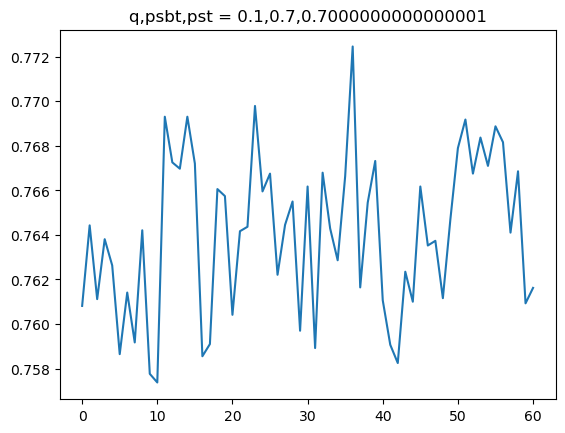

In [8]:
ind = 0

plt.plot(df_w1000.iloc[ind].rho[40:])
plt.title("q,psbt,pst = " + str(df_w1000.iloc[ind].q) + "," + str(df_w1000.iloc[ind].p) + "," + str(df_w1000.iloc[ind].ps) )

## Finding quasi-stationary level

In [9]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def get_zero_crossing(vals):
    zero_crossings = np.where(np.diff(np.sign(vals)))[0]
    return zero_crossings
    

In [10]:


def get_quasilevel_exp(rho, rho_exp):
    
    if np.isnan(rho_exp):
        return get_quasilevel(rho)
    
    crossing = get_zero_crossing(rho - rho_exp)
    if len(crossing) > 1:
        beg = crossing[0]
    else:
        return np.NaN, np.NaN, np.NaN, np.NaN
    
    beg = int(beg - np.sqrt(beg))
    if beg < 0:
        beg = 0

    fin = len(rho)

    m = np.mean(rho[beg:fin])
    s = np.std(rho[beg:fin])
    
    # tt = []
    while not ((m - s < rho[fin-1]) & ( rho[fin-1] < m + s )):
        fin -= 1
        m = np.mean(rho[beg:fin])
        s = np.std(rho[beg:fin])
        # tt.append((m, s, fin))
    
    return m, s, beg, fin

def get_quasilevel(rho, ini_beg = "half"):
    is_correct = False

    if ini_beg == "half":
        beg = int(len(rho) / 2)
    else:
        beg = 0
    fin = len(rho)

    m = np.mean(rho[beg:fin])
    s = np.std(rho[beg:fin])

    is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
    is_correct_fin = ((m - s < rho[fin-1]) & ( rho[fin-1] < m + s ))

    is_correct = is_correct_beg & is_correct_fin

    while not is_correct:
        if np.abs(rho[beg] - m) > np.abs(rho[fin-1] - m):
            beg += 1
        else:
            fin -= 1
        
        if beg == fin:
            return np.NaN, np.NaN, np.NaN, np.NaN
        
        m = np.mean(rho[beg:fin])
        s = np.std(rho[beg:fin])

        is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
        is_correct_fin = ((m - s < rho[fin-1]) & ( rho[fin-1] < m + s ))

        is_correct = is_correct_beg & is_correct_fin
        
    return m, s, beg, fin

def get_quasilevel2(rho, ini_beg = "half", condition = "variance", conditions = [], condition_params = []):
    """Algorithm for looking whether QS exists. 

    Args:
        rho (np.array): a series with densities of positive links
        ini_beg (str, int, optional): Method for choosing initial point of averaging. Possible values:
            "half" : looking for QS state will start at beg = len(rho)/2
            "last20" : checking in the last 20 steps if QS state was reached. 
            (int): checking in the last steps (the number gives number of steps) if QS state was reached. 
            Defaults to "half". If not given, beg will be set to 0. 
        condition (str, int, optional): Method for deciding if QS was found. Possible values:
            "variance" : the beginning value of the range should be between [m-s, m+s]
            "pvalue" : coefficient test is performed. If the pvalue should be above 0.05.
            "R2" : R2 is measured. R2 value should be below 0.3.
            Defaults to "variance". 
        conditions (list): It may contain multiple conditions. 
            Defaults to  [].
        condition_params (float, int, array, optional): Parameters for condition functions. 
            If not given default values will be used. 
            Right now, this fully works only when one condition is chosen. 
            If multiple conditions are chosen, then condition_params contains parameter for coeficient. 
            Defaults to  []. 

    Returns:
        _type_: _description_
    """
    if len(conditions) > 0:
        condition = ""

    if ini_beg == "half":
        beg = int(len(rho) / 2)
    elif ini_beg == "last20":
        beg = len(rho) - 20
    elif ini_beg == 1:
        return rho[-1], 0, len(rho)-1, len(rho)
    elif type(ini_beg) == int:
        beg = len(rho) - ini_beg
    else:
        beg = 0
    fin = len(rho)

    m = np.mean(rho[beg:fin])
    s = np.std(rho[beg:fin])

    is_correct = True
    if (condition == "variance") | ("variance" in conditions):
        is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
        is_correct_fin = True

        is_correct = is_correct & is_correct_beg & is_correct_fin
    if (condition == "pvalue") | ("pvalue" in conditions):  
        mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
        fii = mod.fit()
        p_values = fii.summary2().tables[1]['P>|t|']
        if (condition == []) | (condition_params == []):
            p_value_th = 0.05
        else:
            p_value_th = condition_params
        
        is_correct = is_correct & (p_values.x1 > p_value_th)
        
    if (condition == "R2") | ("R2" in conditions):
        fit = LinearRegression()
        X = np.array(list(range(beg, fin))).reshape(-1, 1)
        y = rho[beg:fin].reshape(-1, 1)
        fit.fit(X, y)
        fit = LinearRegression()
        X = np.array(list(range(beg, fin))).reshape(-1, 1)
        y = rho[beg:fin].reshape(-1, 1)
        fit.fit(X, y)
        
        if (condition == []) | (condition_params == []):
            R2_th = 0.1
        else:
            R2_th = condition_params
        
        is_correct = is_correct & (fit.score(X, y) < R2_th)
    if (condition == "pvalue_or_coef") | ("pvalue_or_coef" in conditions):  
        mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
        fii = mod.fit()
        p_values = fii.summary2().tables[1]['P>|t|']
        coef = fii.params[1]
        
        if (condition == []) | (condition_params == []):
            multiplier = 1
        else:
            multiplier = condition_params
        
        is_correct = is_correct & ((p_values.x1 > 0.05) | (np.abs(coef) < 0.00001*multiplier))
    if (condition == "R2_or_coef") | ("R2_or_coef" in conditions):  
        fit = LinearRegression()
        X = np.array(list(range(beg, fin))).reshape(-1, 1)
        y = rho[beg:fin].reshape(-1, 1)
        fit.fit(X, y)
        coef = fit.coef_
        
        if (condition == []) | (condition_params == []):
            multiplier = 1
        else:
            multiplier = condition_params
        
        is_correct = is_correct & ((fit.score(X, y) < 0.1) | (np.abs(coef) < 0.00001*multiplier))
    

    while not is_correct:
        # if np.abs(rho[beg] - m) > np.abs(rho[fin-1] - m):
        beg += 1
        # else:
        #     fin -= 1
        
        # print(beg)
        # else:
        #     fin -= 1
        
        if beg == fin:
            return np.NaN, np.NaN, np.NaN, np.NaN
        
        m = np.mean(rho[beg:fin])
        s = np.std(rho[beg:fin])

        is_correct = True
        if (condition == "variance") | ("variance" in conditions):
            # print("g")
            is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
            is_correct_fin = True

            is_correct = is_correct & is_correct_beg & is_correct_fin
        if (condition == "pvalue") | ("pvalue" in conditions): 
            if fin- beg < 8:
                is_correct = False
                continue 
            mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
            fii = mod.fit()
            p_values = fii.summary2().tables[1]['P>|t|']
            if (condition == []) | (condition_params == []):
                p_value_th = 0.05
            else:
                p_value_th = condition_params
            
            is_correct = is_correct & (p_values.x1 > p_value_th)
        if (condition == "R2") | ("R2" in conditions):
            fit = LinearRegression()
            X = np.array(list(range(beg, fin))).reshape(-1, 1)
            y = rho[beg:fin].reshape(-1, 1)
            fit.fit(X, y)
            if (condition == []) | (condition_params == []):
                R2_th = 0.1
            else:
                R2_th = condition_params
            
            is_correct = is_correct & (fit.score(X, y) < R2_th)
        if (condition == "pvalue_or_coef") | ("pvalue_or_coef" in conditions):  
            mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
            fii = mod.fit()
            p_values = fii.summary2().tables[1]['P>|t|']
            coef = fii.params[1]
            
            if (condition == []) | (condition_params == []):
                multiplier = 1
            else:
                multiplier = condition_params
            
            is_correct = is_correct & ((p_values.x1 > 0.05) | (np.abs(coef) < 0.00001*multiplier))
        if (condition == "R2_or_coef") | ("R2_or_coef" in conditions):  
            fit = LinearRegression()
            X = np.array(list(range(beg, fin))).reshape(-1, 1)
            y = rho[beg:fin].reshape(-1, 1)
            fit.fit(X, y)
            coef = fit.coef_
            
            if (condition == []) | (condition_params == []):
                multiplier = 1
            else:
                multiplier = condition_params
            
            is_correct = is_correct & ((fit.score(X, y) < 0.1) | (np.abs(coef) < 0.00001*multiplier))
        
        
    return m, s, beg, fin


def get_quasilevels(df, calc_rho = True, calc_triads = True):
    """Automatically finds average values for quasi-stationary state. If it cannot find such a state then, NaN values are given. 

    Args:
        df (_type_): _description_

    Returns:
        _type_: _description_
    """
    df2 = df.copy(deep = True)
    
    if calc_rho:
        ms = np.zeros(len(df2.index))
        ss = np.zeros(len(df2.index))
        begs = np.zeros(len(df2.index))
        fins = np.zeros(len(df2.index))
        
        ms2 = np.zeros(len(df2.index))
        ss2 = np.zeros(len(df2.index))
        begs2 = np.zeros(len(df2.index))
        fins2 = np.zeros(len(df2.index))
        
        ms3 = np.zeros(len(df2.index))
        ss3 = np.zeros(len(df2.index))
        begs3 = np.zeros(len(df2.index))
        fins3 = np.zeros(len(df2.index))
        
        for ind, row in df2.iterrows():
            q = row.q
            psb = row.p
            ps = row.ps
            
            try:
                rho_exp = get_quasi_rho(psb,ps,q)
            except ZeroDivisionError:
                rho_exp = np.NaN
            
            m, s, beg, fin = get_quasilevel_exp(row.rho, rho_exp)
            ms2[ind] = m
            ss2[ind] = s
            begs2[ind] = beg
            fins2[ind] = fin
            
            m, s, beg, fin = get_quasilevel(row.rho)
            ms[ind] = m
            ss[ind] = s
            begs[ind] = beg
            fins[ind] = fin
            
            m, s, beg, fin = get_quasilevel2(row.rho, condition = "pvalue")
            ms3[ind] = m
            ss3[ind] = s
            begs3[ind] = beg
            fins3[ind] = fin
            
        df2['rho_qs_m'] = ms
        df2['rho_qs_s'] = ss
        df2['rho_qs_b'] = begs
        df2['rho_qs_f'] = fins
        df2['rho_qs2_m'] = ms2
        df2['rho_qs2_s'] = ss2
        df2['rho_qs2_b'] = begs2
        df2['rho_qs2_f'] = fins2
        df2['rho_qs3_m'] = ms3
        df2['rho_qs3_s'] = ss3
        df2['rho_qs3_b'] = begs3
        df2['rho_qs3_f'] = fins3
    
    if calc_triads:
        """ get quasi levels of triads"""
        ms = np.zeros(len(df2.index))
        ss = np.zeros(len(df2.index))
        begs = np.zeros(len(df2.index))
        fins = np.zeros(len(df2.index))
        
        ms3 = np.zeros(len(df2.index))
        ss3 = np.zeros(len(df2.index))
        begs3 = np.zeros(len(df2.index))
        fins3 = np.zeros(len(df2.index))
        for i in range(0,8):
            col = 'tr' + str(i)
            for ind, row in df2.iterrows():
                q = row.q
                psb = row.p
                ps = row.ps
                
                m, s, beg, fin = get_quasilevel(row[col])
                ms[ind] = m
                ss[ind] = s
                begs[ind] = beg
                fins[ind] = fin
                
                m, s, beg, fin = get_quasilevel2(row[col], condition = "pvalue")
                ms3[ind] = m
                ss3[ind] = s
                begs3[ind] = beg
                fins3[ind] = fin
            df2[col + '_qs_m'] = ms
            df2[col + '_qs_s'] = ss
            df2[col + '_qs_b'] = begs
            df2[col + '_qs_f'] = fins
            df2[col + '_qs3_m'] = ms3
            df2[col + '_qs3_s'] = ss3
            df2[col + '_qs3_b'] = begs3
            df2[col + '_qs3_f'] = fins3
    
    return df2
  
def group_quasilevels(df, cols = ['q', 'p', 'ps'], calc_rho = True, calc_triads = True):
    mylist = dict()
    
    for group in df.groupby(cols):
        (group_label, df_temp) = group
        columns = [*cols, ]
        q, psb, ps = group_label
        # q = df_temp.q
        # ps = df_temp.ps
        # psb = df_temp.p
        
        d = dict(zip(cols, group_label))
        
        if calc_rho:
            rho_exp = get_quasi_rho(psb,ps,q)
            
            reps = len(df_temp.rho)
            
            to_average = np.sum([not ((np.isnan(val)) | (val == 1)) for val in df_temp.rho_qs_m])
            level = np.mean([val for val in df_temp.rho_qs_m if not ((np.isnan(val)) | (val == 1))])
            level_std = np.std([val for val in df_temp.rho_qs_m if not ((np.isnan(val)) | (val == 1))])
            
            
            to_average2 = np.sum([not ((np.isnan(val)) | (val == 1)) for val in df_temp.rho_qs2_m])
            level2 = np.mean([val for val in df_temp.rho_qs2_m if not ((np.isnan(val)) | (val == 1))])
            level2_std = np.std([val for val in df_temp.rho_qs2_m if not ((np.isnan(val)) | (val == 1))])
            
            to_average3 = np.sum([not ((np.isnan(val)) | (val == 1)) for val in df_temp.rho_qs3_m])
            level3 = np.mean([val for val in df_temp.rho_qs3_m if not ((np.isnan(val)) | (val == 1))])
            level3_std = np.std([val for val in df_temp.rho_qs3_m if not ((np.isnan(val)) | (val == 1))])
            
            d.update({"repetitions": reps, "rho_lvl": level, "rho_lvl_std": level_std, "rho_lvl_valid": to_average, "rho_lvl2": level2, "rho_lvl2_std": level2_std, "rho_lvl2_valid": to_average2,"rho_lvl3": level3, "rho_lvl3_std": level3_std, "rho_lvl3_valid": to_average3, "rho_lvl_exp" : rho_exp})
            columns.extend(["repetitions", "rho_lvl", "rho_lvl_std", "rho_lvl_valid", "rho_lvl2", "rho_lvl2_std", "rho_lvl2_valid", "rho_lvl_exp"])
        
        if calc_triads:
            if "repetitions" in d:
                reps = d["repetitions"]
            else:
                reps = len(df_temp.tr0)
                d.update({"repetitions": reps,})
                columns.extend(["repetitions"])
            
            to_average = np.sum([not ((np.isnan(val)) | (val == 1)) for val in df_temp.tr7_qs_m])
            d.update({"tr_valid": to_average,})
            columns.extend(["tr_valid"])
            
            for i in range(0,8):
                tr_name = 'tr' + str(i)
                col = tr_name + '_qs_m'
                
                level = np.mean([val for val in df_temp[col] if not ((np.isnan(val)) | (val == 1))])
                level_std = np.std([val for val in df_temp[col] if not ((np.isnan(val)) | (val == 1))])
                d.update({tr_name + "_lvl": level, tr_name + "_lvl_std": level_std})
                columns.extend([tr_name + "_lvl", tr_name + "_lvl_std"])
                
                # print("h")
                # print
            
            for i in range(0,8):
                tr_name = 'tr' + str(i)
                col = tr_name + '_qs3_m'
                
                level = np.mean([val for val in df_temp[col] if not ((np.isnan(val)) | (val == 1))])
                level_std = np.std([val for val in df_temp[col] if not ((np.isnan(val)) | (val == 1))])
                d.update({tr_name + "_lvl3": level, tr_name + "_lvl3_std": level_std})
                columns.extend([tr_name + "_lvl3", tr_name + "_lvl3_std"])
            # print(d)
        
        mylist.update({group_label: d})
    
    return pd.DataFrame(data = mylist.values(), index = mylist.keys(), columns = columns)
    

In [11]:
try:
    path = Path("../../outputs/LtdReal/outputs/wiki2-s400-triads/qs_levels.h5")
    df2_w1000 = pd.read_hdf(path)
except FileNotFoundError:
    print("FileNotFoundError")
    df2_w1000 = get_quasilevels(df_w1000)
df2_w1000.head(5)
    

index    q     p   ps  rho_init  steps  \
0      0  0.1  0.70  0.7  0.794729   1000   
1      0  0.5  0.85  0.5  0.794729   1000   
2      0  0.9  0.60  1.0  0.794729   1000   
3      0  0.8  0.10  0.8  0.794729   1000   
4      0  0.4  0.80  0.6  0.794729   1000   

                                                 rho  \
0  [0.7938876744577098, 0.7851752984698167, 0.778...   
1  [0.7928367243988566, 0.8588258785942492, 0.888...   
2  [0.7912813183117539, 0.9304060871027409, 0.954...   
3  [0.7930153859088616, 0.7670464099545989, 0.753...   
4  [0.792647553388263, 0.8637443248696822, 0.8929...   

                                                 tr0  \
0  [0.008107395908714548, 0.010409462953574759, 0...   
1  [0.008823029766355578, 0.0035661305877962356, ...   
2  [0.008853795334067249, 0.00038523841308526477,...   
3  [0.008635761093328018, 0.011649449095692955, 0...   
4  [0.008441804253406618, 0.0027929784948681697, ...   

                                                 tr1  \
0  [0.0323239105979355, 0.03821886089816731, 0.04...   
1  [0.03379798258133814, 0.020888482842845467, 0....   
2  [0.03364415474277979, 0.005691630026659033, 0....   
3  [0.033559883839917384, 0.04295675832576456, 0....   
4  [0.03299941545421348, 0.01836570629048849, 0.0...   

                                                 tr2  ... tr6_qs3_b tr6_qs3_f  \
0  [0.03142368333402444, 0.03631005806666497, 0.0...  ...      50.0     101.0   
1  [0.03363880420926472, 0.016695002200406907, 0....  ...      50.0     101.0   
2  [0.0329900520205621, 0.0027836150612167918, 0....  ...      50.0     101.0   
3  [0.03338331623391998, 0.03499917735547206, 0.0...  ...      50.0     101.0   
4  [0.033265604496588365, 0.014556126427756428, 0...  ...      50.0     101.0   

   tr7_qs_m  tr7_qs_s tr7_qs_b tr7_qs_f  tr7_qs3_m  tr7_qs3_s  tr7_qs3_b  \
0  0.469747  0.007115     51.0    101.0   0.469442   0.007369       50.0   
1  0.893085  0.004555     50.0     98.0   0.893789   0.005257       50.0   
2  0.982386  0.000527     50.0    100.0   0.982371   0.000533       50.0   
3  0.437856  0.006851     50.0    101.0   0.438488   0.006721       55.0   
4  0.901790  0.003786     51.0    101.0   0.901684   0.003822       50.0   

   tr7_qs3_f  
0      101.0  
1      101.0  
2      101.0  
3      101.0  
4      101.0  

[5 rows x 92 columns]

In [190]:
path = Path("../../outputs/LtdReal/outputs/wiki2-s400-triads/qs_levels.h5")
df2_w1000.to_hdf(path, key = 'df2_w1000')

/home/pgorski/.local/lib/python3.8/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['rho', 'tr0', 'tr1', 'tr2', 'tr3', 'tr4', 'tr5', 'tr6', 'tr7', 'Lplus'], dtype='object')]

  pytables.to_hdf(


In [12]:
ind = 0

0.0


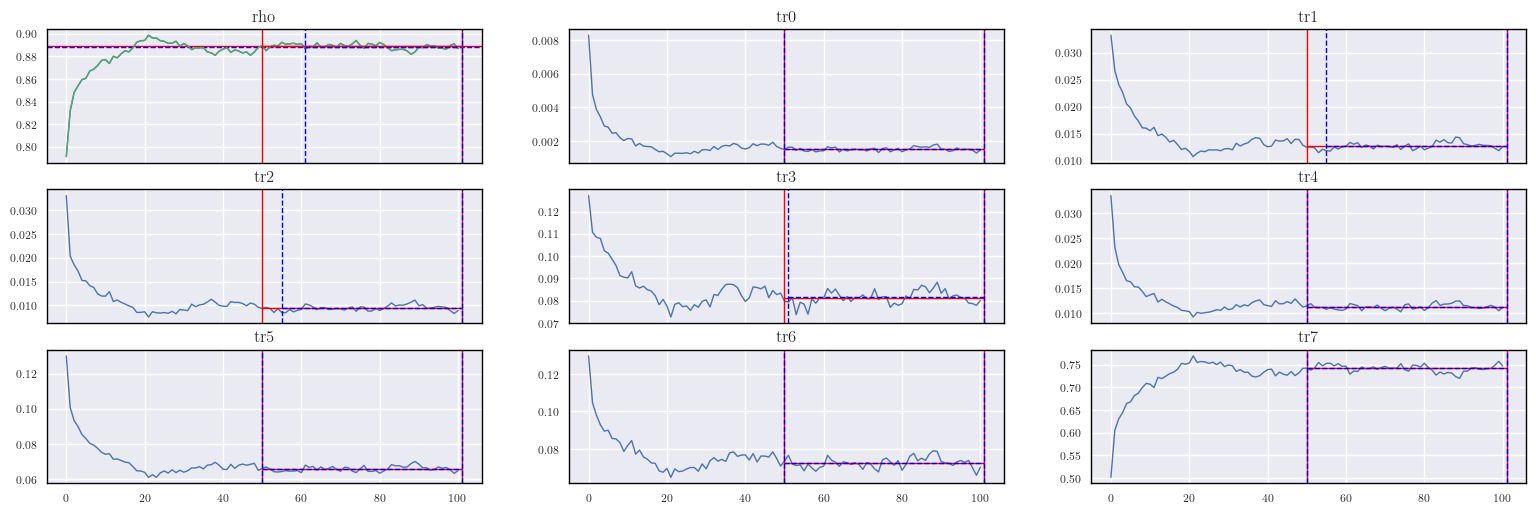

In [48]:
figsize = set_size(width)
figsize = (figsize[0]*4, figsize[1]*2)

fig, axs = plt.subplots(3, 3, figsize=figsize, sharex = True)

cols = ["rho"]
cols1 = ["rho_qs_m"]
cols1b = ["rho_qs_b"]
cols1f = ["rho_qs_f"]
cols3 = ["rho_qs3_m"]
cols3b = ["rho_qs3_b"]
cols3f = ["rho_qs3_f"]
for i in range(8):
    cols.append("tr" + str(i))
    cols1.append("tr" + str(i) + "_qs_m")
    cols1b.append("tr" + str(i) + "_qs_b")
    cols1f.append("tr" + str(i) + "_qs_f")
    cols3.append("tr" + str(i) + "_qs3_m")
    cols3b.append("tr" + str(i) + "_qs3_b")
    cols3f.append("tr" + str(i) + "_qs3_f")

axs.flatten()[0].plot(df2_w1000.rho[ind])
axs.flatten()[0].axhline(df2_w1000.rho_qs_m[ind], color = "red")
axs.flatten()[0].axhline(df2_w1000.rho_qs3_m[ind], color = "blue", linestyle = '--')

for i, ax in enumerate(axs.flatten()):
    
    ax.plot(df2_w1000[cols[i]][ind])
    ax.hlines(y = df2_w1000[cols1[i]][ind], color = "red", xmin = df2_w1000[cols1b[i]][ind], xmax = df2_w1000[cols1f[i]][ind])
    ax.hlines(y = df2_w1000[cols3[i]][ind], color = "blue", linestyle = '--', xmin = df2_w1000[cols3b[i]][ind], xmax = df2_w1000[cols3f[i]][ind])
    
    ax.axvline(df2_w1000[cols1b[i]][ind], color = "red")
    ax.axvline(df2_w1000[cols1f[i]][ind], color = "red")
    ax.axvline(df2_w1000[cols3b[i]][ind], color = "blue", linestyle = '--')
    ax.axvline(df2_w1000[cols3f[i]][ind], color = "blue", linestyle = '--')
    
    ax.set_title(cols[i])

print(difs[ind])    
ind += 1


In [49]:
len(df2_w1000)

895

In [50]:
difs = []
difs2 = np.zeros(len(df2_w1000))

for i in range(0,8):
    tr_name = 'tr' + str(i)
    col1 = tr_name + '_qs3_m'
    col2 = tr_name + '_qs_m'
    
    difs.extend(np.abs(df2_w1000[col1] - df2_w1000[col2]).values)
    difs2 += np.abs(df2_w1000[col1] - df2_w1000[col2]).values

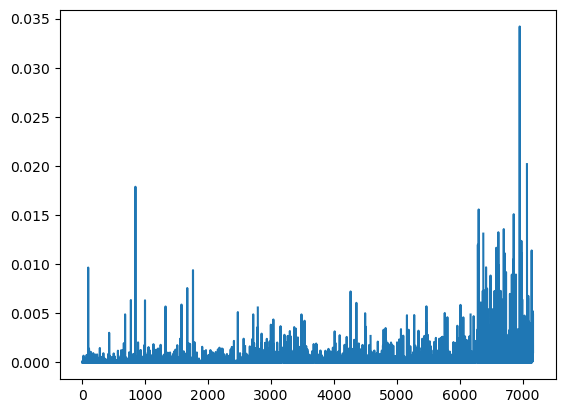

In [23]:
plt.plot(difs)

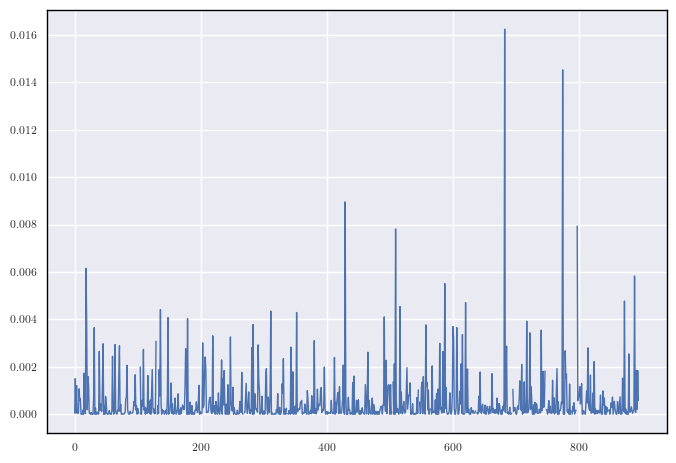

In [51]:
difs3 = np.abs(df2_w1000["rho_qs_m"] - df2_w1000["rho_qs3_m"]).values


# plt.scatter(df2_w1000["rho_qs_m"], df2_w1000["rho_qs3_m"])
plt.plot(difs3)

<Axes: >

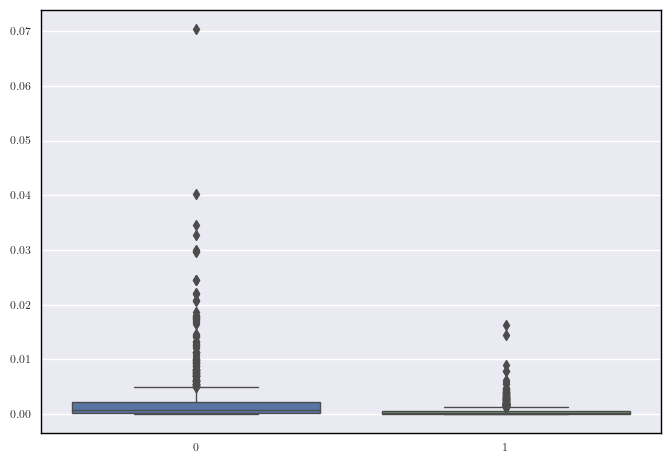

In [93]:
inds2 = np.where(np.logical_not(np.isnan(difs2)))
inds3 = np.where(np.logical_not(np.isnan(difs3)))
sns.boxplot(
    data=[difs2[inds2], difs3[inds3]])

# np.quantile(difs2[inds2], 0.75), np.quantile(difs3[inds3], 0.75)

In [174]:
ind = 0

sp2 = (np.quantile(difs2[inds2], 0.75) - np.quantile(difs2[inds2], 0.25))*10 + np.quantile(difs2[inds2], 0.75)
sp3 = (np.quantile(difs3[inds3], 0.75) - np.quantile(difs3[inds3], 0.25))*8 + np.quantile(difs3[inds3], 0.75)
sp2, sp3

(0.021215881603799672, 0.004613260184432644)

In [175]:
np.sum(difs3 > sp3)

10

nan
0.004031676612401891
179


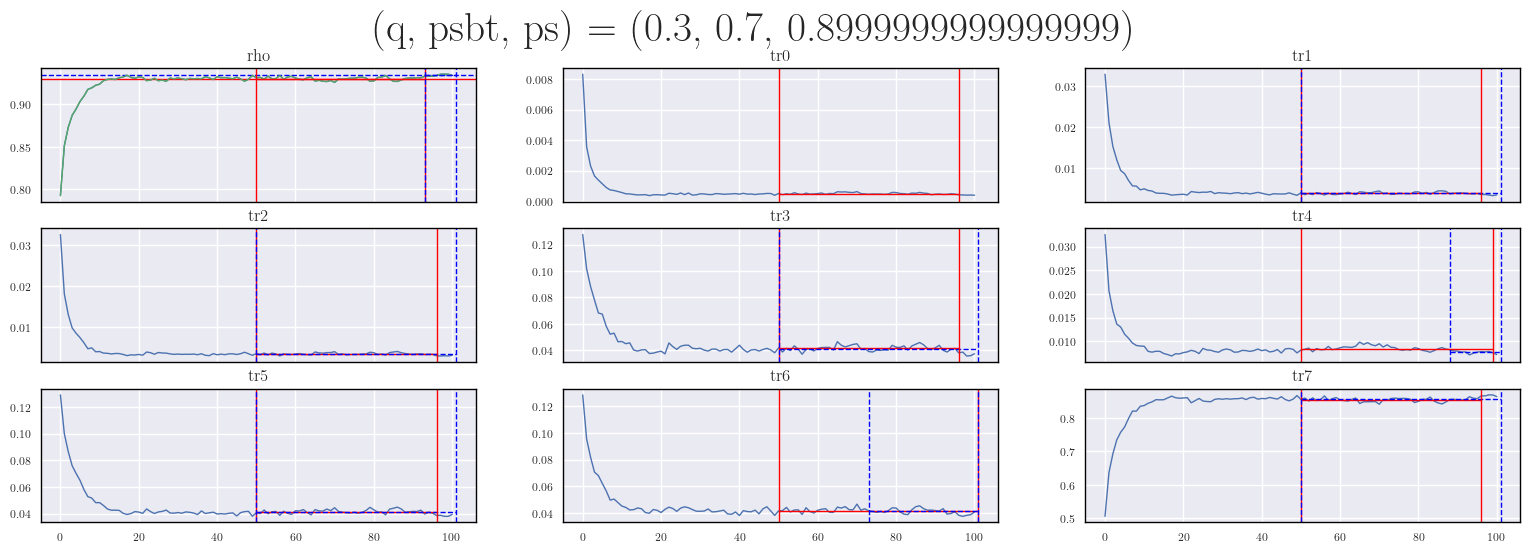

In [184]:
while (difs2[ind] <= sp2 ) and (difs3[ind] < sp3):
    ind += 1


figsize = set_size(width)
figsize = (figsize[0]*4, figsize[1]*2)

fig, axs = plt.subplots(3, 3, figsize=figsize, sharex = True)

cols = ["rho"]
cols1 = ["rho_qs_m"]
cols1b = ["rho_qs_b"]
cols1f = ["rho_qs_f"]
cols3 = ["rho_qs3_m"]
cols3b = ["rho_qs3_b"]
cols3f = ["rho_qs3_f"]
for i in range(8):
    cols.append("tr" + str(i))
    cols1.append("tr" + str(i) + "_qs_m")
    cols1b.append("tr" + str(i) + "_qs_b")
    cols1f.append("tr" + str(i) + "_qs_f")
    cols3.append("tr" + str(i) + "_qs3_m")
    cols3b.append("tr" + str(i) + "_qs3_b")
    cols3f.append("tr" + str(i) + "_qs3_f")

axs.flatten()[0].plot(df2_w1000.rho[ind])
axs.flatten()[0].axhline(df2_w1000.rho_qs_m[ind], color = "red")
axs.flatten()[0].axhline(df2_w1000.rho_qs3_m[ind], color = "blue", linestyle = '--')

for i, ax in enumerate(axs.flatten()):
    
    ax.plot(df2_w1000[cols[i]][ind])
    ax.hlines(y = df2_w1000[cols1[i]][ind], color = "red", xmin = df2_w1000[cols1b[i]][ind], xmax = df2_w1000[cols1f[i]][ind])
    ax.hlines(y = df2_w1000[cols3[i]][ind], color = "blue", linestyle = '--', xmin = df2_w1000[cols3b[i]][ind], xmax = df2_w1000[cols3f[i]][ind])
    
    ax.axvline(df2_w1000[cols1b[i]][ind], color = "red")
    ax.axvline(df2_w1000[cols1f[i]][ind], color = "red")
    ax.axvline(df2_w1000[cols3b[i]][ind], color = "blue", linestyle = '--')
    ax.axvline(df2_w1000[cols3f[i]][ind], color = "blue", linestyle = '--')
    
    ax.set_title(cols[i])


fig.suptitle('(q, psbt, ps) = (' + str(df2_w1000.q[ind]) + ', ' + str(df2_w1000.p[ind]) + ', ' + str(df2_w1000.ps[ind]) + ')', fontsize=30)
print(difs2[ind])    
print(difs3[ind])  
print(ind)  
ind += 1


todo

* przeszukac pvaluejuz wczesniej, nie tykklo od pol.

In [189]:
df2_w1000_g = group_quasilevels(df2_w1000)
df2_w1000_g

/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'to_average3' is not defined

In [24]:
qs = [.95, .8, .1]
n1_triads = ['tr3', 'tr5', 'tr6']
n1_nohierarchical = 'tr5'
n2_triads = ['tr1', 'tr2', 'tr4']
n2_nonhierarchical = 'tr2'

triad_names_map={
    'tr7': 'BH0',
    'tr4': 'BH1',
    'tr1': 'BH2',
    'tr2': 'BN1',
    'tr0': 'UH2',
    'tr3': 'UH1',
    'tr5': 'UN1',
    'tr6': 'UH0',
}
triad_names_map.update({value: key for key, value in triad_names_map.items()})
# triad_names_map

# Finding best simulation stopping time

In [155]:


import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore", message="kurtosistest only valid for n>=20 ... continuing ")
warnings.filterwarnings("ignore", message="omni_normtest is not valid with less than 8 observations; %i ")


def get_quasilevel_ending(rho, ini_beg = "half", condition = "variance", conditions = [], condition_params = []):
    """Algorithm for looking whether QS exists. 

    Args:
        rho (np.array): a series with densities of positive links
        ini_beg (str, int, optional): Method for choosing initial point of averaging. Possible values:
            "half" : looking for QS state will start at beg = len(rho)/2
            "last20" : checking in the last 20 steps if QS state was reached. 
            (int): checking in the last steps (the number gives number of steps) if QS state was reached. 
            Defaults to "half". If not given, beg will be set to 0. 
        condition (str, int, optional): Method for deciding if QS was found. Possible values:
            "variance" : the beginning value of the range should be between [m-s, m+s]
            "pvalue" : coefficient test is performed. If the pvalue should be above 0.05.
            "R2" : R2 is measured. R2 value should be below 0.3.
            Defaults to "variance". 
        conditions (list): It may contain multiple conditions. 
            Defaults to  [].
        condition_params (float, int, array, optional): Parameters for condition functions. 
            If not given default values will be used. 
            Right now, this fully works only when one condition is chosen. 
            If multiple conditions are chosen, then condition_params contains parameter for coeficient. 
            Defaults to  []. 

    Returns:
        _type_: _description_
    """
    if len(conditions) > 0:
        condition = ""

    if ini_beg == "half":
        beg = int(len(rho) / 2)
    elif ini_beg == "last20":
        beg = len(rho) - 20
    elif ini_beg == 1:
        return rho[-1], 0, len(rho)-1, len(rho)
    elif type(ini_beg) == int:
        beg = len(rho) - ini_beg
    else:
        beg = 0
    fin = len(rho)

    m = np.mean(rho[beg:fin])
    s = np.std(rho[beg:fin])

    is_correct = True
    if (condition == "variance") | ("variance" in conditions):
        is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
        is_correct_fin = True

        is_correct = is_correct & is_correct_beg & is_correct_fin
    if (condition == "pvalue") | ("pvalue" in conditions):  
        mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
        fii = mod.fit()
        p_values = fii.summary2().tables[1]['P>|t|']
        if (condition == []) | (condition_params == []):
            p_value_th = 0.05
        else:
            p_value_th = condition_params
        
        is_correct = is_correct & (p_values.x1 > p_value_th)
        
    if (condition == "R2") | ("R2" in conditions):
        fit = LinearRegression()
        X = np.array(list(range(beg, fin))).reshape(-1, 1)
        y = rho[beg:fin].reshape(-1, 1)
        fit.fit(X, y)
        fit = LinearRegression()
        X = np.array(list(range(beg, fin))).reshape(-1, 1)
        y = rho[beg:fin].reshape(-1, 1)
        fit.fit(X, y)
        
        if (condition == []) | (condition_params == []):
            R2_th = 0.1
        else:
            R2_th = condition_params
        
        is_correct = is_correct & (fit.score(X, y) < R2_th)
    if (condition == "pvalue_or_coef") | ("pvalue_or_coef" in conditions):  
        mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
        fii = mod.fit()
        p_values = fii.summary2().tables[1]['P>|t|']
        coef = fii.params[1]
        
        if (condition == []) | (condition_params == []):
            multiplier = 1
        else:
            multiplier = condition_params
        
        is_correct = is_correct & ((p_values.x1 > 0.05) | (np.abs(coef) < 0.00001*multiplier))
    if (condition == "R2_or_coef") | ("R2_or_coef" in conditions):  
        fit = LinearRegression()
        X = np.array(list(range(beg, fin))).reshape(-1, 1)
        y = rho[beg:fin].reshape(-1, 1)
        fit.fit(X, y)
        coef = fit.coef_
        
        if (condition == []) | (condition_params == []):
            multiplier = 1
        else:
            multiplier = condition_params
        
        is_correct = is_correct & ((fit.score(X, y) < 0.1) | (np.abs(coef) < 0.00001*multiplier))
    

    while not is_correct:
        # if np.abs(rho[beg] - m) > np.abs(rho[fin-1] - m):
        beg += 1
        
        # print(beg)
        # else:
        #     fin -= 1
        
        if beg == fin:
            return np.NaN, np.NaN, np.NaN, np.NaN
        
        m = np.mean(rho[beg:fin])
        s = np.std(rho[beg:fin])

        is_correct = True
        if (condition == "variance") | ("variance" in conditions):
            # print("g")
            is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
            is_correct_fin = True

            is_correct = is_correct & is_correct_beg & is_correct_fin
        if (condition == "pvalue") | ("pvalue" in conditions):  
            mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
            fii = mod.fit()
            p_values = fii.summary2().tables[1]['P>|t|']
            if (condition == []) | (condition_params == []):
                p_value_th = 0.05
            else:
                p_value_th = condition_params
            
            is_correct = is_correct & (p_values.x1 > p_value_th)
        if (condition == "R2") | ("R2" in conditions):
            fit = LinearRegression()
            X = np.array(list(range(beg, fin))).reshape(-1, 1)
            y = rho[beg:fin].reshape(-1, 1)
            fit.fit(X, y)
            if (condition == []) | (condition_params == []):
                R2_th = 0.1
            else:
                R2_th = condition_params
            
            is_correct = is_correct & (fit.score(X, y) < R2_th)
        if (condition == "pvalue_or_coef") | ("pvalue_or_coef" in conditions):  
            mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
            fii = mod.fit()
            p_values = fii.summary2().tables[1]['P>|t|']
            coef = fii.params[1]
            
            if (condition == []) | (condition_params == []):
                multiplier = 1
            else:
                multiplier = condition_params
            
            is_correct = is_correct & ((p_values.x1 > 0.05) | (np.abs(coef) < 0.00001*multiplier))
        if (condition == "R2_or_coef") | ("R2_or_coef" in conditions):  
            fit = LinearRegression()
            X = np.array(list(range(beg, fin))).reshape(-1, 1)
            y = rho[beg:fin].reshape(-1, 1)
            fit.fit(X, y)
            coef = fit.coef_
            
            if (condition == []) | (condition_params == []):
                multiplier = 1
            else:
                multiplier = condition_params
            
            is_correct = is_correct & ((fit.score(X, y) < 0.1) | (np.abs(coef) < 0.00001*multiplier))
        
        
    return m, s, beg, fin

def get_quasilevel_rigid(rho, ini_beg = "half", condition = "variance", conditions = [], condition_params = []):
    """Algorithm for checking whether QS exists in the specified range, which is not modified by the function. 

    Args:
        rho (np.array): a series with densities of positive links
        ini_beg (str, int, optional): Choice for initial point of averaging. Possible values:
            "half" : looking for QS state will start at beg = len(rho)/2
            "last20" : checking in the last 20 steps if QS state was reached. 
            (int): checking in the last steps (the number gives number of steps) if QS state was reached. 
            Defaults to "half". If not given, beg will be set to 0. 
        condition (str, int, optional): Method for deciding if QS was found. Possible values:
            "variance" : the beginning value of the range should be between [m-s, m+s]
            "pvalue" : coefficient test is performed. If the pvalue should be above 0.05.
            Defaults to "variance". 
        conditions (list): It may contain multiple conditions. 
            Defaults to  []. 
        condition_params (float, int, array, optional): Parameters for condition functions. 
            If not given default values will be used. 
            Right now, this fully works only when one condition is chosen. 
            If multiple conditions are chosen, then condition_params contains parameter for coeficient. 
            Defaults to  []. 

    Returns:
        _type_: _description_
    """
    
    if len(conditions) > 0:
        condition = ""
        
    # print("fff")

    if ini_beg == "half":
        beg = int(len(rho) / 2)
    elif ini_beg == "last20":
        beg = len(rho) - 20
    elif ini_beg == 1:
        return rho[-1], 0, len(rho)-1, len(rho)
    elif type(ini_beg) == int:
        beg = len(rho) - ini_beg
    else:
        beg = 0
    fin = len(rho)

    m = np.mean(rho[beg:fin])
    s = np.std(rho[beg:fin])
    
    is_correct = True
    if (condition == "variance") | ("variance" in conditions):
        is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
        is_correct_fin = True

        is_correct = is_correct & is_correct_beg & is_correct_fin
    if (condition == "pvalue") | ("pvalue" in conditions):  
        mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
        fii = mod.fit()
        p_values = fii.summary2().tables[1]['P>|t|']
        
        if (condition == []) | (condition_params == []):
            p_value_th = 0.05
        else:
            p_value_th = condition_params
        
        is_correct = is_correct & (p_values.x1 > p_value_th)
    if (condition == "R2") | ("R2" in conditions):
        fit = LinearRegression()
        X = np.array(list(range(beg, fin))).reshape(-1, 1)
        y = rho[beg:fin].reshape(-1, 1)
        fit.fit(X, y)
        
        if (condition == []) | (condition_params == []):
            R2_th = 0.1
        else:
            R2_th = condition_params
        
        is_correct = is_correct & (fit.score(X, y) < R2_th)
    if (condition == "pvalue_or_coef") | ("pvalue_or_coef" in conditions):  
        mod = sm.OLS(rho[beg:fin], sm.add_constant(list(range(beg, fin))))
        fii = mod.fit()
        p_values = fii.summary2().tables[1]['P>|t|']
        coef = fii.params[1]
        
        if (condition == []) | (condition_params == []):
            multiplier = 1
        else:
            multiplier = condition_params
        
        is_correct = is_correct & ((p_values.x1 > 0.05) | (np.abs(coef) < 0.00001*multiplier))
    if (condition == "R2_or_coef") | ("R2_or_coef" in conditions):  
        fit = LinearRegression()
        X = np.array(list(range(beg, fin))).reshape(-1, 1)
        y = rho[beg:fin].reshape(-1, 1)
        fit.fit(X, y)
        coef = fit.coef_
        
        if (condition == []) | (condition_params == []):
            multiplier = 1
        else:
            multiplier = condition_params
        
        is_correct = is_correct & ((fit.score(X, y) < 0.1) | (np.abs(coef) < 0.00001*multiplier))
    # else: 
    #     is_correct = True
        
    # print("t")
    if is_correct:
        # print(p_values)
        # print(coef)
        return m, s, beg, fin
    else:
        return np.NaN, np.NaN, np.NaN, np.NaN

def get_quasilevel_first_ending(rho, ini_beg = "half", min_points = 20, condition = "variance", conditions = []):
    """Algorithm for looking when QS would be detected first. 

    Args:
        rho (np.array): a series with densities of positive links
        ini_beg (str, optional): Method for choosing initial point of averaging. Possible values:
            "half" : looking for QS state will start at beg = len(rho)/2
            "last20" : checking in the last 20 steps if QS state was reached. 
            (int): checking in the last steps (the number gives number of steps) if QS state was reached. 
            Defaults to "half". If not given, beg will be set to 0. 
        min_points (int): how many initial points should be considered at minimum. 
            Defaults to 20.

    Returns:
        _type_: _description_
    """
    for cur_fin in range(min_points, len(rho)):
        rho_ = rho[0:cur_fin]
        
        m, s, beg, fin = get_quasilevel_ending(rho_, ini_beg=ini_beg, condition=condition, conditions = conditions)
        if not np.isnan(m):
            return m, s, beg, fin
    return np.nan, np.nan, np.nan, np.nan

def get_quasilevel_rigid_first_ending(rho, ini_beg = "half", min_points = 20, condition = "variance",conditions = [], condition_params = []):
    """Algorithm for looking when QS would be detected first. 

    Args:
        rho (np.array): a series with densities of positive links
        ini_beg (str, optional): Method for choosing initial point of averaging. Possible values:
            "half" : looking for QS state will start at beg = len(rho)/2
            "last20" : checking in the last 20 steps if QS state was reached. 
            (int): checking in the last steps (the number gives number of steps) if QS state was reached. 
            Defaults to "half". If not given, beg will be set to 0. 
        min_points (int): how many initial points should be considered at minimum. 
            Defaults to 20.

    Returns:
        _type_: _description_
    """
    for cur_fin in range(min_points, len(rho)):
        rho_ = rho[0:cur_fin]
        # print("ddd")
        m, s, beg, fin = get_quasilevel_rigid(rho_, ini_beg=ini_beg, 
                                              condition=condition, 
                                              conditions = conditions, 
                                              condition_params = condition_params)
        if not np.isnan(m):
            return m, s, beg, fin
    return np.nan, np.nan, np.nan, np.nan

In [156]:
df2 = df_w1000
get_quasilevel_ending(df2.iloc[36].rho, ini_beg=30)


# m = np.mean(rho[beg:fin])
# rho = df2.iloc[15].rho
# beg = 221
# fin = 300

# m = np.mean(rho[beg:fin])
# # m == rho[-1]
# s = np.std(rho[beg:fin])
# m, s, m-s, rho[beg], 

(0.972280141247688, 0.0005260254389937999, 71, 101)

In [30]:
get_quasilevel_rigid_first_ending(df2.iloc[36].rho, ini_beg=10, min_points=30)

(0.9720783588363882, 0.00047226847189647765, 20, 30)

In [157]:
import time
start_time = time.time()
res = get_quasilevel_rigid_first_ending(df2.iloc[36].rho, ini_beg=18, 
                                  min_points=70, condition = "pvalue")
print(res)
print("--- %s seconds ---" % (time.time() - start_time))

(0.9723384105898398, 0.00036675450485394213, 52, 70)
--- 0.01568770408630371 seconds ---


In [158]:
start_time = time.time()
res = get_quasilevel_rigid_first_ending(df2.iloc[36].rho, ini_beg=18, 
                                  min_points=70, condition = "R2")
print(res)
print("--- %s seconds ---" % (time.time() - start_time))

(0.9723238140612447, 0.0003828437668656767, 54, 72)
--- 0.009366989135742188 seconds ---


In [212]:
from sklearn.linear_model import LinearRegression

beg = 100-20
fin = 100

fit = LinearRegression()
X = np.array(list(range(beg, fin))).reshape(-1, 1)
y = df2.iloc[0].rho[beg:fin].reshape(-1, 1)
fit.fit(X, y)
fit.coef_, fit.score(X, y)
# df2.iloc[15].rho[beg:fin]
# np.array(list(range(beg, fin)))a

(array([[0.00034911]]), 0.3619035271990708)

In [36]:
import statsmodels.api as sm
mod = sm.OLS(y, sm.add_constant(X))
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
p_values
# fii.summary2()

const    4.903772e-36
x1       3.955120e-04
Name: P>|t|, dtype: float64

In [64]:
rho = df2.iloc[0].rho
get_quasilevel_ending(rho, "last20")

# beg = 52
# fin = len(rho)

# m = np.mean(rho[beg:fin])
# s = np.std(rho[beg:fin])
# m-s, rho[beg], m+s

(0.7651389355977805, 0.002833900144574533, 83, 101)

In [173]:
ind = 483
res = get_quasilevel_rigid_first_ending(df2.iloc[ind].rho, ini_beg=18, 
                                  min_points=70, condition = "pvalue", condition_params=0.01)
res, get_quasilevel_rigid_first_ending(df2.iloc[ind].rho, ini_beg=18,  min_points=70, condition = "pvalue", condition_params=0.05)

((0.9622271033013844, 0.0005996174354785983, 52, 70),
 (0.9622271033013844, 0.0005996174354785983, 52, 70))

In [65]:
df2 = df_w1000

# ms = np.zeros(len(df2.index))
# ss = np.zeros(len(df2.index))
# begs = np.zeros(len(df2.index))
# fins = np.zeros(len(df2.index))

# ms2 = np.zeros(len(df2.index))
# ss2 = np.zeros(len(df2.index))
# begs2 = np.zeros(len(df2.index))
# fins2 = np.zeros(len(df2.index))

ms = np.zeros(len(df2.index))
ss = np.zeros(len(df2.index))
begs = np.zeros(len(df2.index))
fins = np.zeros(len(df2.index))

ms2 = np.zeros(len(df2.index))
ss2 = np.zeros(len(df2.index))
begs2 = np.zeros(len(df2.index))
fins2 = np.zeros(len(df2.index))

ms_f = np.zeros(len(df2.index))
ss_f = np.zeros(len(df2.index))
begs_f = np.zeros(len(df2.index))
fins_f = np.zeros(len(df2.index))

ms_f100 = np.zeros(len(df2.index))
ss_f100 = np.zeros(len(df2.index))
begs_f100 = np.zeros(len(df2.index))
fins_f100 = np.zeros(len(df2.index))

for ind, row in df2.iterrows():
    q = row.q
    psb = row.p
    ps = row.ps
    
    m, s, beg, fin = get_quasilevel_ending(row.rho, "half")
    ms2[ind] = m
    ss2[ind] = s
    begs2[ind] = beg
    fins2[ind] = fin
    
    m, s, beg, fin = get_quasilevel_ending(row.rho, "last20")
    ms[ind] = m
    ss[ind] = s
    begs[ind] = beg
    fins[ind] = fin
    
    m, s, beg, fin = get_quasilevel_first_ending(row.rho, "last20")
    ms_f[ind] = m
    ss_f[ind] = s
    begs_f[ind] = beg
    fins_f[ind] = fin
    
    m, s, beg, fin = get_quasilevel_first_ending(row.rho, 10, min_points=10)
    ms_f100[ind] = m
    ss_f100[ind] = s
    begs_f100[ind] = beg
    fins_f100[ind] = fin

In [66]:
ms

array([0.76513894, 0.94464015, 0.98320582, 0.73325311, 0.94505015,
       0.96727867, 0.96655719, 0.95324533, 0.7217925 , 0.50746437,
       0.62943501, 0.93848842, 0.96485402, 0.96303311, 0.5814439 ,
       0.88474809, 0.8871075 , 0.95886529, 0.87776085, 0.84650191,
       0.96188625, 0.86036079, 0.61119367, 0.98395024, 0.95669087,
       0.9591832 , 0.92079598, 0.96992759, 0.95111663, 0.93859824,
       0.83781615, 0.87017456, 0.88875927, 0.95658525, 0.82052611,
       0.96246269, 0.97225713, 0.61267551, 0.69263126, 0.55050147,
       0.96950143, 0.7888594 , 0.53246034, 0.9519658 , 0.80470353,
       0.9443543 , 0.7859938 , 0.58678903, 0.92692534, 0.59005959,
       0.9738547 , 0.94927642, 0.97424987, 0.7229827 , 0.96549416,
       0.91547577, 0.98281752, 0.94245786, 0.93805203, 0.9529285 ,
       0.90074565, 0.96022522, 0.76471908, 0.7041255 , 0.93137506,
       0.94040693, 0.96158224, 0.55898983, 0.96791062, 0.59025725,
       0.37317555, 0.61488344, 0.67212145, 0.94830797, 0.65314

(array([  1.,   1.,   6.,  36., 336., 481.,  26.,   3.,   2.,   1.]),
 array([-1.58494080e-02, -1.26936169e-02, -9.53782578e-03, -6.38203465e-03,
        -3.22624353e-03, -7.04524112e-05,  3.08533871e-03,  6.24112983e-03,
         9.39692095e-03,  1.25527121e-02,  1.57085032e-02]),
 <BarContainer object of 10 artists>)

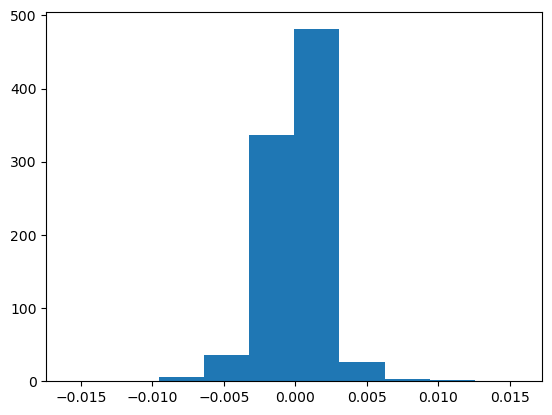

In [67]:
errs = (ms - ms2) / ms2

plt.hist(errs)

(array([  1.,   0.,   0.,   1.,   2.,  45., 839.,   1.,   0.,   2.]),
 array([-0.01219922, -0.01021181, -0.00822441, -0.006237  , -0.0042496 ,
        -0.00226219, -0.00027478,  0.00171262,  0.00370003,  0.00568743,
         0.00767484]),
 <BarContainer object of 10 artists>)

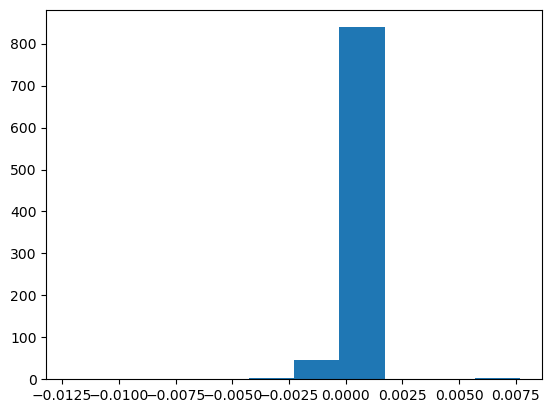

In [68]:
err2 = (ms2 - df2_w1000.rho_qs_m) / df2_w1000.rho_qs_m

plt.hist(err2)

(array([  1.,   0.,   1.,   0.,  21., 287., 564.,  13.,   2.,   2.]),
 array([-0.02785528, -0.02325677, -0.01865827, -0.01405977, -0.00946127,
        -0.00486277, -0.00026426,  0.00433424,  0.00893274,  0.01353124,
         0.01812974]),
 <BarContainer object of 10 artists>)

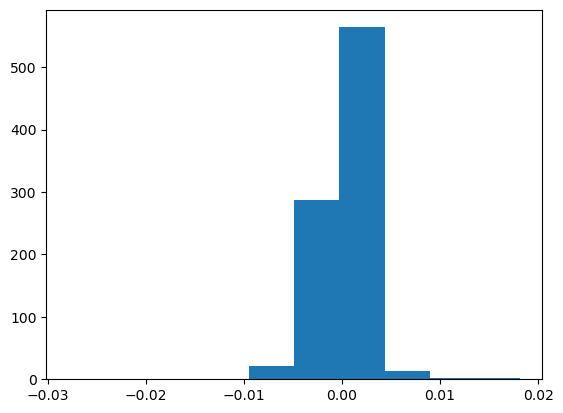

In [69]:
err3 = (ms - df2_w1000.rho_qs_m) / df2_w1000.rho_qs_m

plt.hist(err3)

(array([  4.,   9., 790.,  76.,   5.,   1.,   4.,   0.,   1.,   1.]),
 array([-0.10259928, -0.06420399, -0.0258087 ,  0.01258659,  0.05098188,
         0.08937716,  0.12777245,  0.16616774,  0.20456303,  0.24295832,
         0.28135361]),
 <BarContainer object of 10 artists>)

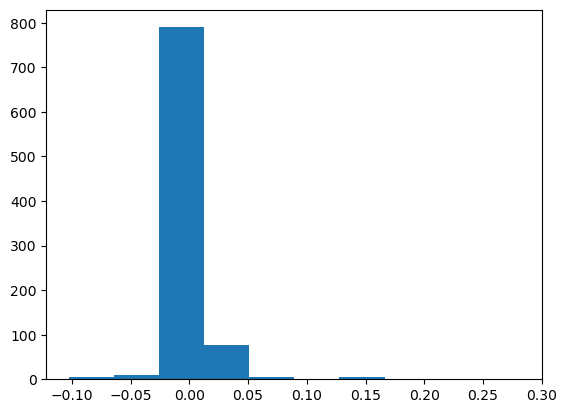

In [70]:
err_f = (ms_f - df2_w1000.rho_qs_m) / df2_w1000.rho_qs_m

plt.hist(err_f)

(array([641., 243.,   3.,   1.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.1267337 ,  0.00221864,  0.13117097,  0.26012331,  0.38907565,
         0.51802799,  0.64698032,  0.77593266,  0.904885  ,  1.03383733,
         1.16278967]),
 <BarContainer object of 10 artists>)

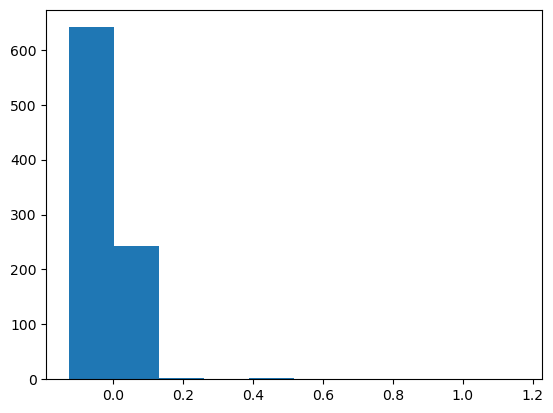

In [71]:
err_f100 = (ms_f100 - df2_w1000.rho_qs_m) / df2_w1000.rho_qs_m

plt.hist(err_f100)

Above we can see that stoping when my algorithm found QS state leads to poor results. 

# How does error change with increasing minimum number of points considered?

In [75]:
df2

index    q     p   ps  rho_init  steps  \
0        0  0.1  0.70  0.7  0.794729   1000   
1        0  0.5  0.85  0.5  0.794729   1000   
2        0  0.9  0.60  1.0  0.794729   1000   
3        0  0.8  0.10  0.8  0.794729   1000   
4        0  0.4  0.80  0.6  0.794729   1000   
..     ...  ...   ...  ...       ...    ...   
890      0  0.4  0.80  0.7  0.794729   1000   
891      0  0.8  0.70  0.6  0.794729   1000   
892      0  0.6  0.30  1.0  0.794729   1000   
893      0  0.1  0.75  0.5  0.794729   1000   
894      0  0.9  0.45  0.7  0.794729   1000   

                                                   rho  \
0    [0.7938876744577098, 0.7851752984698167, 0.778...   
1    [0.7928367243988566, 0.8588258785942492, 0.888...   
2    [0.7912813183117539, 0.9304060871027409, 0.954...   
3    [0.7930153859088616, 0.7670464099545989, 0.753...   
4    [0.792647553388263, 0.8637443248696822, 0.8929...   
..                                                 ...   
890  [0.7941188834706575, 0.8808748108289894, 0.909...   
891  [0.7942975449806625, 0.8387106944677989, 0.860...   
892  [0.7924058348747267, 0.7778081385572557, 0.769...   
893  [0.7918067933411804, 0.8191630233731293, 0.831...   
894  [0.7924583823776694, 0.8564402219606524, 0.879...   

                                                   tr0  \
0    [0.008107395908714548, 0.010409462953574759, 0...   
1    [0.008823029766355578, 0.0035661305877962356, ...   
2    [0.008853795334067249, 0.00038523841308526477,...   
3    [0.008635761093328018, 0.011649449095692955, 0...   
4    [0.008441804253406618, 0.0027929784948681697, ...   
..                                                 ...   
890  [0.009050427440746186, 0.0021335252391354075, ...   
891  [0.00833880648324146, 0.004929179000761113, 0....   
892  [0.009090556442109234, 0.010709092830418853, 0...   
893  [0.009026350039928356, 0.006593194923948854, 0...   
894  [0.009010298439383137, 0.003768113227990246, 0...   

                                                   tr1  \
0    [0.0323239105979355, 0.03821886089816731, 0.04...   
1    [0.03379798258133814, 0.020888482842845467, 0....   
2    [0.03364415474277979, 0.005691630026659033, 0....   
3    [0.033559883839917384, 0.04295675832576456, 0....   
4    [0.03299941545421348, 0.01836570629048849, 0.0...   
..                                                 ...   
890  [0.034307620898648854, 0.014849068137706681, 0...   
891  [0.03275730381265642, 0.0276849980403671, 0.02...   
892  [0.034184558627802175, 0.04189735268978008, 0....   
893  [0.034238063962952904, 0.029232639859602002, 0...   
894  [0.03409226192466716, 0.023734966672864368, 0....   

                                                   tr2  ... tr5_qs_b tr5_qs_f  \
0    [0.03142368333402444, 0.03631005806666497, 0.0...  ...     53.0    101.0   
1    [0.03363880420926472, 0.016695002200406907, 0....  ...     50.0     98.0   
2    [0.0329900520205621, 0.0027836150612167918, 0....  ...     50.0     99.0   
3    [0.03338331623391998, 0.03499917735547206, 0.0...  ...     50.0    101.0   
4    [0.033265604496588365, 0.014556126427756428, 0...  ...     50.0    100.0   
..                                                 ...  ...      ...      ...   
890  [0.03390633088501837, 0.01186213280291711, 0.0...  ...     52.0    101.0   
891  [0.03276265434617149, 0.019751494470892427, 0....  ...     56.0    101.0   
892  [0.03467948297794644, 0.03581513371652071, 0.0...  ...     50.0    100.0   
893  [0.03536167600111826, 0.026938598615014398, 0....  ...     50.0    100.0   
894  [0.03454705727344838, 0.015382783855835224, 0....  ...     51.0    101.0   

     tr6_qs_m  tr6_qs_s tr6_qs_b tr6_qs_f  tr7_qs_m  tr7_qs_s  tr7_qs_b  \
0    0.125981  0.002076     50.0    101.0  0.469747  0.007115      51.0   
1    0.032331  0.001659     50.0     98.0  0.893085  0.004555      50.0   
2    0.008213  0.000214     50.0    100.0  0.982386  0.000527      50.0   
3    0.137925  0.001710     50.0    100.0  0.437856  0.006851      50.0   
4

In [76]:
df2 = df2_w1000

min_points_range = list(range(2, 100))

err_fs = np.zeros(len(min_points_range))
err_fs2 = np.zeros(len(min_points_range))

maxerr_fs = np.zeros(len(min_points_range))
maxerr_fs2 = np.zeros(len(min_points_range))

for i, min_points in enumerate(min_points_range):

    ms_f = np.zeros(len(df2.index))
    ss_f = np.zeros(len(df2.index))
    begs_f = np.zeros(len(df2.index))
    fins_f = np.zeros(len(df2.index))
    
    ms_f2 = np.zeros(len(df2.index))
    ss_f2 = np.zeros(len(df2.index))
    begs_f2 = np.zeros(len(df2.index))
    fins_f2 = np.zeros(len(df2.index))

    for ind, row in df2.iterrows():
        q = row.q
        psb = row.p
        ps = row.ps
        
        m, s, beg, fin = get_quasilevel_first_ending(row.rho, "last20", 
                                                     min_points=min_points)
        ms_f[ind] = m
        ss_f[ind] = s
        begs_f[ind] = beg
        fins_f[ind] = fin
        
        m, s, beg, fin = get_quasilevel_first_ending(row.rho, "half", 
                                                     min_points=min_points)
        ms_f2[ind] = m
        ss_f2[ind] = s
        begs_f2[ind] = beg
        fins_f2[ind] = fin
    
    err = (ms_f - df2_w1000.rho_qs_m) / df2_w1000.rho_qs_m
    err_fs[i] = np.sum(err**2)
    maxerr_fs[i] = np.max(np.abs(err))
    
    err = (ms_f2 - df2_w1000.rho_qs_m) / df2_w1000.rho_qs_m
    err_fs2[i] = np.sum(err**2)
    maxerr_fs2[i] = np.max(np.abs(err))


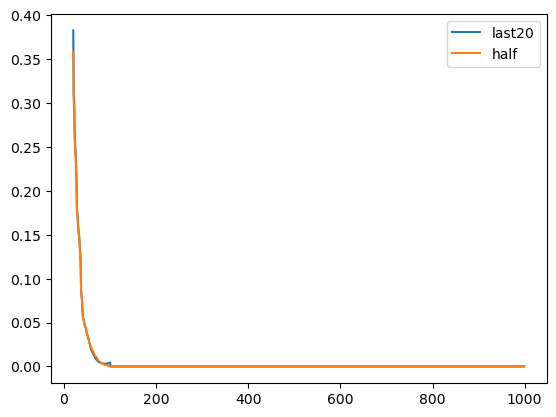

In [78]:
plt.plot(min_points_range, err_fs, min_points_range, err_fs2)

# plt.yscale('log')
plt.legend(["last20", "half"])

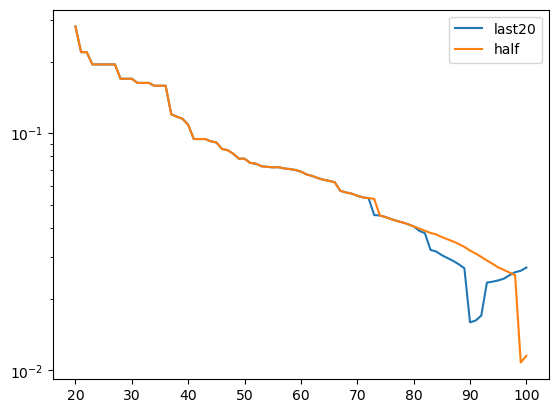

In [81]:
plt.plot(min_points_range, maxerr_fs, min_points_range, maxerr_fs2)

plt.yscale('log')
plt.legend(["last20", "half"])

In [28]:
#find rows for which we don't have values

exclude_ = np.where(np.isnan(df2_w1000.rho_qs3_m))[0]
include_ = [i for i in range(len(df2_w1000.rho_qs3_m)) if i not in exclude_]

correct_rhos = [rho for i, rho in enumerate(df2_w1000.rho_qs3_m) if i not in exclude_]
len(exclude_)

15

In [29]:

import itertools
from itertools import permutations

df2 = df_w1000.iloc[include_].reset_index()

min_points_range = np.array([20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
last_points = np.array([10, 100, 150, 200, 250, 300, 350, 400, 500])

min_points_range = (min_points_range / 10).astype(int)
last_points = np.ceil(last_points / 10).astype(int)

# print(min_points_range)
# 0/0

# err_fs = np.zeros(len(min_points_range))
# err_fs2 = np.zeros(len(min_points_range))

# maxerr_fs = np.zeros(len(min_points_range))
# maxerr_fs2 = np.zeros(len(min_points_range))

mpr = []
lp = []
err_fs3 = []
maxerr_fs3 = []
mederr_fs3 = []

unique_combinations = []
 
for i in range(len(min_points_range)):
    for j in range(len(last_points)):
        unique_combinations.append((min_points_range[i], last_points[j]))

for i, (min_points, last_point) in enumerate(unique_combinations):

    if min_points < last_point:
        continue
    
    if i%10 == 0:
        print("Finished " + str(float(i) / len(unique_combinations) * 100))

    mpr.append(min_points)
    lp.append(last_point)

    ms_f = np.zeros(len(df2.index))
    ss_f = np.zeros(len(df2.index))
    begs_f = np.zeros(len(df2.index))
    fins_f = np.zeros(len(df2.index))
    
    ms_f2 = np.zeros(len(df2.index))
    ss_f2 = np.zeros(len(df2.index))
    begs_f2 = np.zeros(len(df2.index))
    fins_f2 = np.zeros(len(df2.index))

    for ind, row in df2.iterrows():
        q = row.q
        psb = row.p
        ps = row.ps
        
        m, s, beg, fin = get_quasilevel_first_ending(row.rho, last_point, 
                                                     min_points=min_points)
        
        # if np.isnan(m):
        #     0/0
        ms_f[ind] = m
        ss_f[ind] = s
        begs_f[ind] = beg
        fins_f[ind] = fin
        
    err = (ms_f - correct_rhos) / correct_rhos
    
    if any(np.isnan(err)):
        0/0
    err_fs3.append(np.sum(err**2))
    maxerr_fs3.append(np.max(np.abs(err)))
    mederr_fs3.append(np.median(np.abs(err)))
    


Finished 0.0
Finished 27.77777777777778
Finished 37.03703703703704
Finished 46.2962962962963
Finished 55.55555555555556
Finished 64.81481481481481
Finished 74.07407407407408
Finished 83.33333333333334
Finished 92.5925925925926


In [30]:
err_df = pd.DataFrame({"min_points": mpr, 
                       "last_point": lp, "sumerr": err_fs3, 
                       "maxerr": maxerr_fs3, "mederr": mederr_fs3})

In [31]:
err_df

min_points  last_point     sumerr    maxerr    mederr
0            2           1  13.797829  0.990039  0.074526
1            5           1   3.883227  0.685406  0.027332
2           10           1   1.298011  0.429330  0.009905
3           10          10   0.914277  0.416814  0.009992
4           20           1   0.350792  0.268159  0.003280
..         ...         ...        ...       ...       ...
71         100          25   0.007972  0.058680  0.000667
72         100          30   0.007972  0.058680  0.000667
73         100          35   0.007972  0.058680  0.000667
74         100          40   0.007972  0.058680  0.000667
75         100          50   0.007972  0.058680  0.000667

[76 rows x 5 columns]

<Axes: xlabel='min_points', ylabel='last_point'>

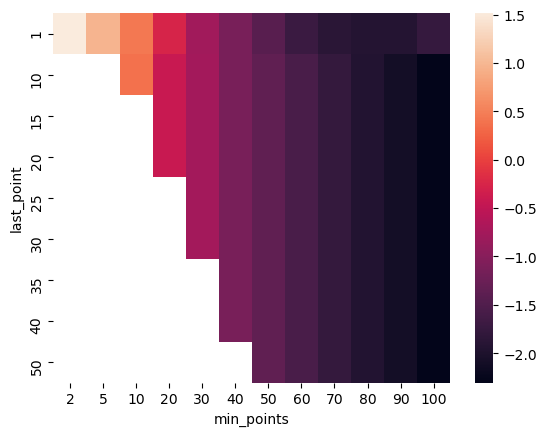

In [121]:
pv = pd.pivot_table(err_df, values = "sumerr", index = "last_point", columns = "min_points")

# if log == True:
pv = np.log10(pv)


sns.heatmap(pv)

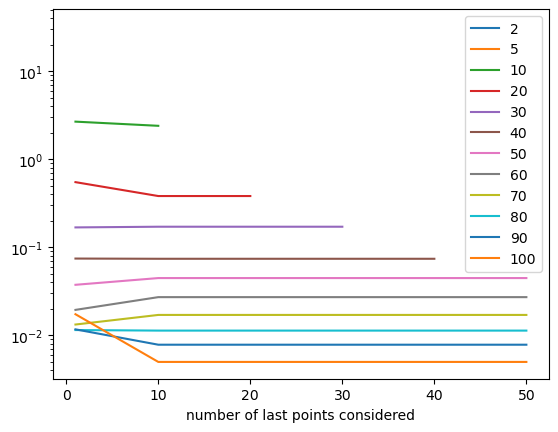

In [122]:
pv = pd.pivot_table(err_df, values = "sumerr", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale("log")

<Axes: xlabel='min_points', ylabel='last_point'>

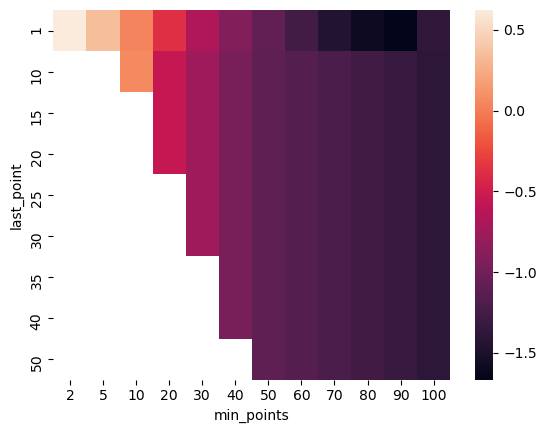

In [123]:
pv = pd.pivot_table(err_df, values = "maxerr", index = "last_point", columns = "min_points")

# if log == True:
pv = np.log10(pv)


sns.heatmap(pv)

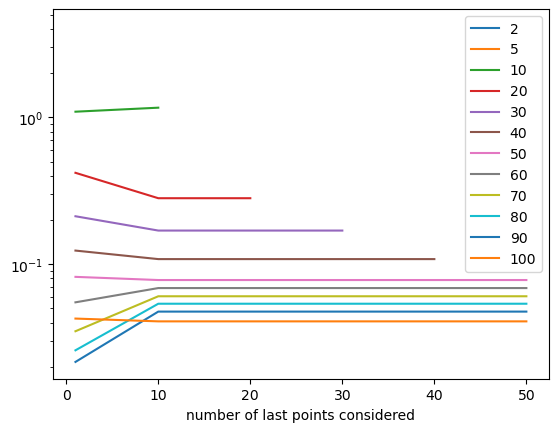

In [124]:
pv = pd.pivot_table(err_df, values = "maxerr", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')

<Axes: xlabel='min_points', ylabel='last_point'>

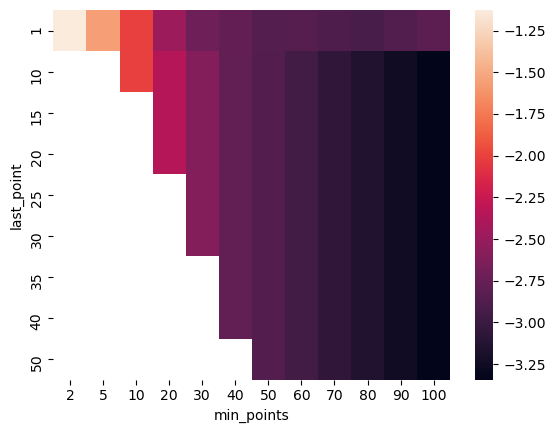

In [125]:
pv = pd.pivot_table(err_df, values = "mederr", index = "last_point", columns = "min_points")

# if log == True:
pv = np.log10(pv)

pv
sns.heatmap(pv)

Text(0.5, 1.0, 'median error')

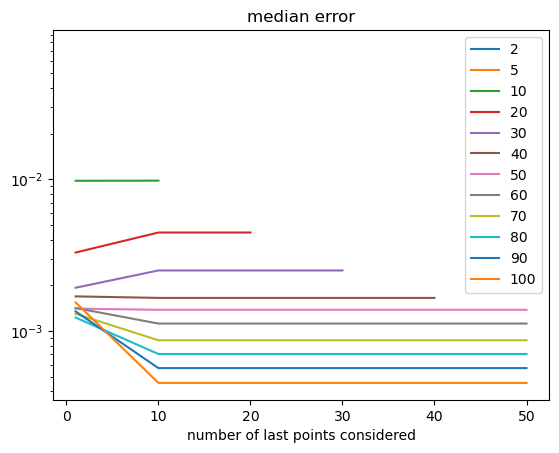

In [126]:
pv = pd.pivot_table(err_df, values = "mederr", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("median error")

In [265]:

import itertools
from itertools import permutations

df2 = df_w1000.iloc[include_].reset_index()

# err_fs = np.zeros(len(min_points_range))
# err_fs2 = np.zeros(len(min_points_range))

# maxerr_fs = np.zeros(len(min_points_range))
# maxerr_fs2 = np.zeros(len(min_points_range))


err_fs3 = []
maxerr_fs3 = []
mederr_fs3 = []
fins_f_fs3 = []
failed_f_fs3 = []

for i, pars in err_df.iterrows():
    min_points = int(pars.min_points)
    last_point = int(pars.last_point)
    
    if i%10 == 0:
        print("Finished " + str(float(i) / len(err_df) * 100))
    
    if min_points < last_point:
        continue


    ms_f = np.zeros(len(df2.index))
    ss_f = np.zeros(len(df2.index))
    begs_f = np.zeros(len(df2.index))
    fins_f = np.zeros(len(df2.index))
    
    ms_f2 = np.zeros(len(df2.index))
    ss_f2 = np.zeros(len(df2.index))
    begs_f2 = np.zeros(len(df2.index))
    fins_f2 = np.zeros(len(df2.index))

    for ind, row in df2.iterrows():
        q = row.q
        psb = row.p
        ps = row.ps
        
        m, s, beg, fin = get_quasilevel_rigid_first_ending(row.rho, last_point, 
                                                     min_points=min_points, 
                                                     condition="R2")
        ms_f[ind] = m
        ss_f[ind] = s
        begs_f[ind] = beg
        fins_f[ind] = fin
        
        # if np.isnan(m):
        #     print(row.level_0)
            # 0/0
        
    err = (ms_f - correct_rhos) / correct_rhos
    err_fs3.append(np.nansum(err**2))
    maxerr_fs3.append(np.nanmax(np.abs(err)))
    mederr_fs3.append(np.nanmedian(np.abs(err)))
    fins_f_fs3.append(np.nanmean(fins_f))
    failed_f_fs3.append(np.sum(np.isnan(err)))

err_df['sumerr_R2_rigid'] = err_fs3
err_df['maxerr_R2_rigid'] = maxerr_fs3
err_df['mederr_R2_rigid'] = mederr_fs3
err_df['fins_R2_rigid'] = fins_f_fs3
err_df['failed_R2_rigid'] = failed_f_fs3


Finished 0.0
Finished 13.157894736842104
Finished 26.31578947368421
Finished 39.473684210526315
Finished 52.63157894736842
Finished 65.78947368421053
Finished 78.94736842105263
Finished 92.10526315789474


In [199]:
ind = 214
df2_w1000[["rho_qs_m", "rho_qs3_m", "rho_qs3_b", "rho_qs3_f"]].iloc[ind],  df2_w1000.iloc[ind].rho_qs3_f

(rho_qs_m       0.953769
 rho_qs3_m      0.954457
 rho_qs3_b     74.000000
 rho_qs3_f    101.000000
 Name: 214, dtype: float64,
 101.0)

In [207]:
err_df[err_df.last_point == 20]

min_points  last_point    sumerr    maxerr    mederr  sumerr_R2_rigid  \
7           20          20  0.350375  0.276782  0.004302              NaN   
11          30          20  0.141304  0.165276  0.002478              NaN   
17          40          20  0.066688  0.104379  0.001669              NaN   
25          50          20  0.038005  0.074185  0.001337              NaN   
34          60          20  0.023715  0.065562  0.001105              NaN   
43          70          20  0.014906  0.059407  0.000911              NaN   
52          80          20  0.009761  0.052726  0.000758              NaN   
61          90          20  0.006830  0.046469  0.000620              NaN   
70         100          20  0.004602  0.039710  0.000517              NaN   

    maxerr_R2_rigid  mederr_R2_rigid  fins_R2_rigid  
7               NaN              NaN            NaN  
11              NaN              NaN            NaN  
17              NaN              NaN            NaN  
25              NaN              NaN            NaN  
34              NaN              NaN            NaN  
43              NaN              NaN            NaN  
52              NaN              NaN            NaN  
61              NaN              NaN            NaN  
70              NaN              NaN            NaN

In [246]:
min_points = 20
last_point = 20

ms_f = np.zeros(len(df2.index))
ss_f = np.zeros(len(df2.index))
begs_f = np.zeros(len(df2.index))
fins_f = np.zeros(len(df2.index))

ms_f2 = np.zeros(len(df2.index))
ss_f2 = np.zeros(len(df2.index))
begs_f2 = np.zeros(len(df2.index))
fins_f2 = np.zeros(len(df2.index))

for ind, row in df2.iterrows():
    q = row.q
    psb = row.p
    ps = row.ps
    
    m, s, beg, fin = get_quasilevel_rigid_first_ending(row.rho, last_point, 
                                                    min_points=min_points, 
                                                    condition="R2")
    ms_f[ind] = m
    ss_f[ind] = s
    begs_f[ind] = beg
    fins_f[ind] = fin
    
    if np.isnan(m):
        print(row.level_0)
        print((q, psb, ps))
        # 0/0
    
err = (ms_f - correct_rhos) / correct_rhos
# err_fs3.append(np.sum(err**2))
# maxerr_fs3.append(np.max(np.abs(err)))
# mederr_fs3.append(np.median(np.abs(err)))
# fins_f_fs3.append(np.mean(fins_f))

96
(0.95, 0.9, 0.45)


In [264]:
np.nansum(err**2)

0.030708207946202035

In [248]:
inds = np.where(np.isnan(ms_f))[0]
# df2.iloc[inds]
inds

array([95])

Text(0.5, 1.0, 'sum error rigid R2')

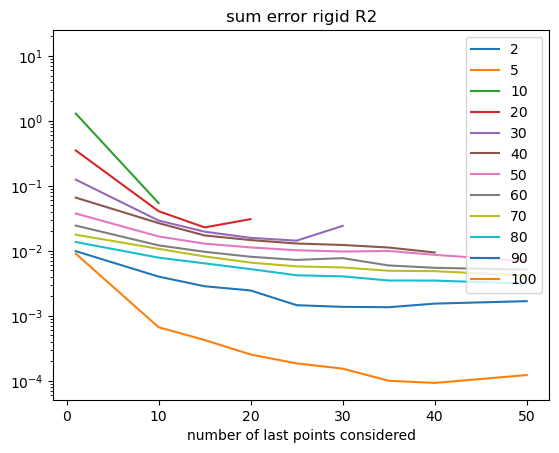

In [266]:
pv = pd.pivot_table(err_df, values = "sumerr_R2_rigid", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("sum error rigid R2")

Text(0.5, 1.0, 'max error rigid R2')

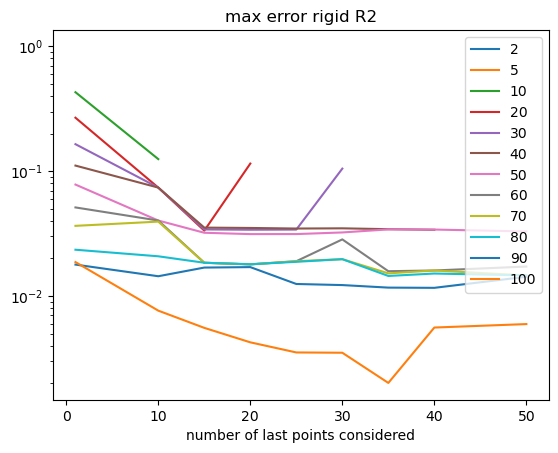

In [267]:
pv = pd.pivot_table(err_df, values = "maxerr_R2_rigid", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("max error rigid R2")

Text(0.5, 1.0, 'med error rigid R2')

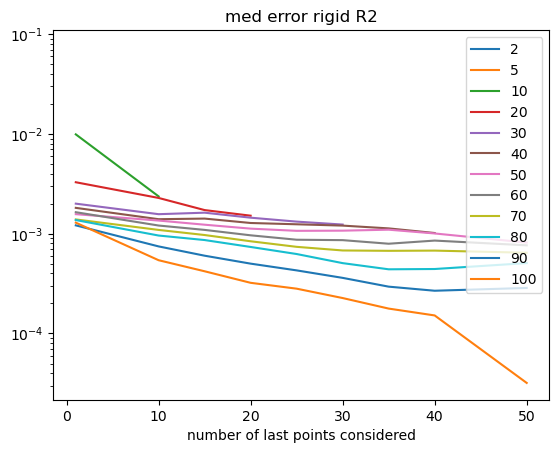

In [268]:
pv = pd.pivot_table(err_df, values = "mederr_R2_rigid", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("med error rigid R2")

Text(0.5, 1.0, 'med error rigid R2')

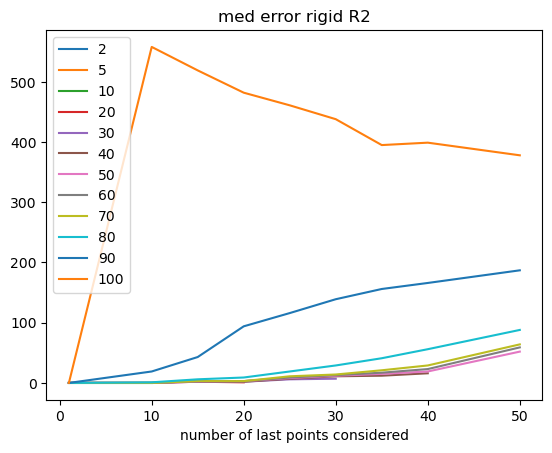

In [270]:
pv = pd.pivot_table(err_df, values = "failed_R2_rigid", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
# plt.yscale('log')
plt.title("med error rigid R2")

In [32]:

import itertools
from itertools import permutations

df2 = df_w1000.iloc[include_].reset_index()

# err_fs = np.zeros(len(min_points_range))
# err_fs2 = np.zeros(len(min_points_range))

# maxerr_fs = np.zeros(len(min_points_range))
# maxerr_fs2 = np.zeros(len(min_points_range))


err_fs3 = []
maxerr_fs3 = []
mederr_fs3 = []
fins_f_fs3 = []
failed_f_fs3 = []

for i, pars in err_df.iterrows():
    min_points = int(pars.min_points)
    last_point = int(pars.last_point)
    
    if i%10 == 0:
        print("Finished " + str(float(i) / len(err_df) * 100))
    
    if min_points < last_point:
        continue


    ms_f = np.zeros(len(df2.index))
    ss_f = np.zeros(len(df2.index))
    begs_f = np.zeros(len(df2.index))
    fins_f = np.zeros(len(df2.index))
    
    ms_f2 = np.zeros(len(df2.index))
    ss_f2 = np.zeros(len(df2.index))
    begs_f2 = np.zeros(len(df2.index))
    fins_f2 = np.zeros(len(df2.index))

    for ind, row in df2.iterrows():
        q = row.q
        psb = row.p
        ps = row.ps
        
        m, s, beg, fin = get_quasilevel_rigid_first_ending(row.rho, last_point, 
                                                     min_points=min_points, 
                                                     condition="pvalue")
        ms_f[ind] = m
        ss_f[ind] = s
        begs_f[ind] = beg
        fins_f[ind] = fin
        
    err = (ms_f - correct_rhos) / correct_rhos
    err_fs3.append(np.nansum(err**2))
    maxerr_fs3.append(np.nanmax(np.abs(err)))
    mederr_fs3.append(np.nanmedian(np.abs(err)))
    fins_f_fs3.append(np.mean(fins_f))
    failed_f_fs3.append(np.sum(np.isnan(err))/len(df2))

err_df['sumerr_pv_rigid'] = err_fs3
err_df['maxerr_pv_rigid'] = maxerr_fs3
err_df['mederr_pv_rigid'] = mederr_fs3
err_df['fins_pv_rigid'] = fins_f_fs3
err_df['failed_pv_rigid'] = failed_f_fs3
    


Finished 0.0
Finished 13.157894736842104
Finished 26.31578947368421
Finished 39.473684210526315
Finished 52.63157894736842
Finished 65.78947368421053
Finished 78.94736842105263
Finished 92.10526315789474


In [272]:
err_df

min_points  last_point     sumerr    maxerr    mederr  sumerr_R2_rigid  \
0            2           1  15.290908  1.271425  0.074586        13.797829   
1            5           1   4.500389  0.834706  0.027372         3.883227   
2           10           1   1.475591  0.476158  0.009574         1.298011   
3           10          10   1.038489  0.403683  0.009738         0.054237   
4           20           1   0.367669  0.268159  0.003198         0.350792   
..         ...         ...        ...       ...       ...              ...   
71         100          25   0.004602  0.039710  0.000517         0.000184   
72         100          30   0.004602  0.039710  0.000517         0.000153   
73         100          35   0.004602  0.039710  0.000517         0.000100   
74         100          40   0.004602  0.039710  0.000517         0.000092   
75         100          50   0.004602  0.039710  0.000517         0.000122   

    maxerr_R2_rigid  mederr_R2_rigid  fins_R2_rigid  failed_R2_rigid  \
0          0.990039         0.074526       2.000000         0.000000   
1          0.685406         0.027332       5.000000         0.000000   
2          0.429330         0.009905      10.000000         0.000000   
3          0.125003         0.002367      27.232955         0.000000   
4          0.268159         0.003280      20.000000         0.000000   
..              ...              ...            ...              ...   
71         0.003531         0.000281     100.000000         0.420455   
72         0.003513         0.000227     100.000000         0.447727   
73         0.002013         0.000178     100.000000         0.427273   
74         0.005592         0.000152     100.000000         0.463636   
75         0.005960         0.000032     100.000000         0.487500   

    sumerr_pv_rigid  maxerr_pv_rigid  mederr_pv_rigid  fins_pv_rigid  
0         13.797829         0.990039         0.074526       2.000000  
1          3.883227         0.685406         0.027332       5.000000  
2          1.298011         0.429330         0.009905      10.000000  
3          0.107629         0.129736         0.003327      23.480682  
4          0.350792         0.268159         0.003280      20.000000  
..              ...              ...              ...            ...  
71              NaN              NaN              NaN            NaN  
72              NaN              NaN              NaN            NaN  
73              NaN              NaN              NaN            NaN  
74              NaN              NaN              NaN            NaN  
75              NaN              NaN              NaN            NaN  

[76 rows x 14 columns]

Text(0.5, 1.0, 'sum error rigid pvalue')

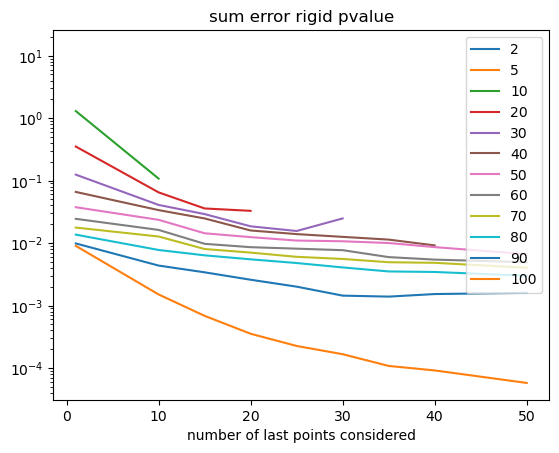

In [33]:
pv = pd.pivot_table(err_df, values = "sumerr_pv_rigid", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("sum error rigid pvalue")

Text(0.5, 1.0, 'max error rigid pvalue')

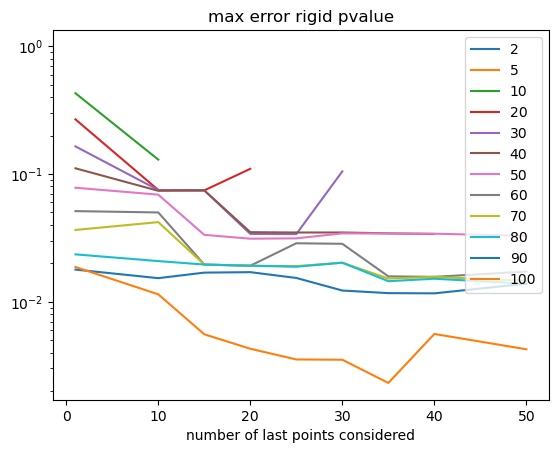

In [34]:
pv = pd.pivot_table(err_df, values = "maxerr_pv_rigid", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("max error rigid pvalue")

Text(0.5, 1.0, 'med error rigid pvalue')

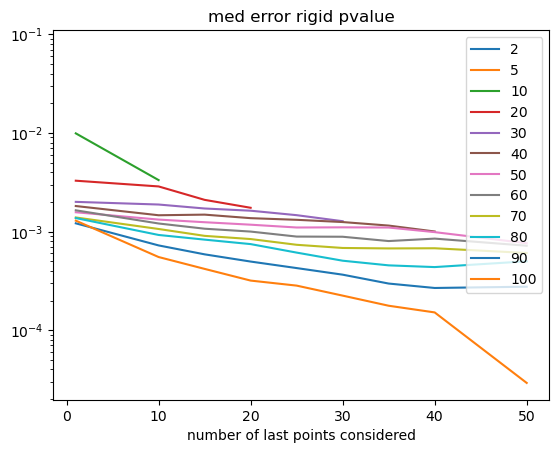

In [35]:
pv = pd.pivot_table(err_df, values = "mederr_pv_rigid", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("med error rigid pvalue")

Text(0.5, 1.0, 'failed ratio rigid pvalue')

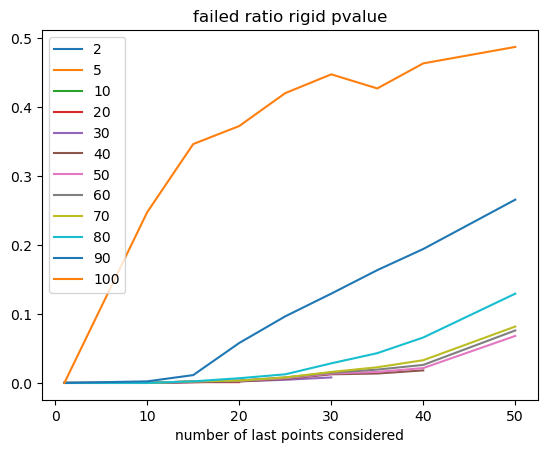

In [37]:
pv = pd.pivot_table(err_df, values = "failed_pv_rigid", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
# plt.yscale('log')
plt.title("failed ratio rigid pvalue")

In [39]:
"""Testing R2 and coef for rho"""

start_from_beg = True

In [41]:

import itertools
from itertools import permutations

df2 = df_w1000.iloc[include_].reset_index()

if start_from_beg:
    start_from = 0
    start_from_beg = False
    
    err_fs3 = np.full(len(err_df), np.nan)
    maxerr_fs3 = np.full(len(err_df), np.nan)
    mederr_fs3 = np.full(len(err_df), np.nan)
    fins_f_fs3 = np.full(len(err_df), np.nan)


# err_fs = np.zeros(len(min_points_range))
# err_fs2 = np.zeros(len(min_points_range))

# maxerr_fs = np.zeros(len(min_points_range))
# maxerr_fs2 = np.zeros(len(min_points_range))

for i, pars in err_df.iterrows():
    if not start_from_beg:
        if start_from > i:
            continue
    
    min_points = int(pars.min_points)
    last_point = int(pars.last_point)
    
    if i%10 == 0:
        print("Finished " + str(float(i) / len(err_df) * 100))
    
    if min_points < last_point:
        continue


    ms_f = np.zeros(len(df2.index))
    ss_f = np.zeros(len(df2.index))
    begs_f = np.zeros(len(df2.index))
    fins_f = np.zeros(len(df2.index))
    
    ms_f2 = np.zeros(len(df2.index))
    ss_f2 = np.zeros(len(df2.index))
    begs_f2 = np.zeros(len(df2.index))
    fins_f2 = np.zeros(len(df2.index))

    for ind, row in df2.iterrows():
        q = row.q
        psb = row.p
        ps = row.ps
        
        m, s, beg, fin = get_quasilevel_rigid_first_ending(row.rho, last_point, 
                                                     min_points=min_points, 
                                                     condition="R2_or_coef")
        ms_f[ind] = m
        ss_f[ind] = s
        begs_f[ind] = beg
        fins_f[ind] = fin
        
    err = (ms_f - correct_rhos) / correct_rhos
    err_fs3[i] = (np.nansum(err**2))
    maxerr_fs3[i] = (np.nanmax(np.abs(err)))
    mederr_fs3[i] = (np.nanmedian(np.abs(err)))
    fins_f_fs3[i] = (np.mean(fins_f))
    failed_f_fs3[i] = (np.sum(np.isnan(err))/len(df2))
    
    start_from = i

err_df['sumerr_R2_or_coef_rigid'] = err_fs3
err_df['maxerr_R2_or_coef_rigid'] = maxerr_fs3
err_df['mederr_R2_or_coef_rigid'] = mederr_fs3
err_df['fins_R2_or_coef_rigid'] = fins_f_fs3
err_df['failed_R2_or_coef_rigid'] = failed_f_fs3
    


Finished 0.0
Finished 13.157894736842104
Finished 26.31578947368421
Finished 39.473684210526315
Finished 52.63157894736842
Finished 65.78947368421053
Finished 78.94736842105263
Finished 92.10526315789474


In [429]:
len(err_fs3)

49

Text(0.5, 1.0, 'sum error rigid pvalue or coef')

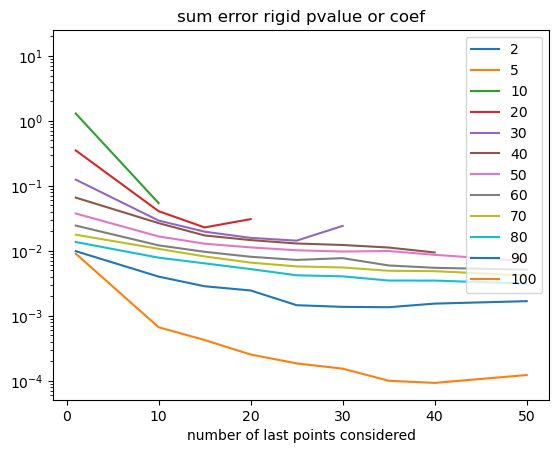

In [42]:
pv = pd.pivot_table(err_df, values = "sumerr_R2_or_coef_rigid", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("sum error rigid pvalue or coef")

Text(0.5, 1.0, 'max error rigid pvalue or coef')

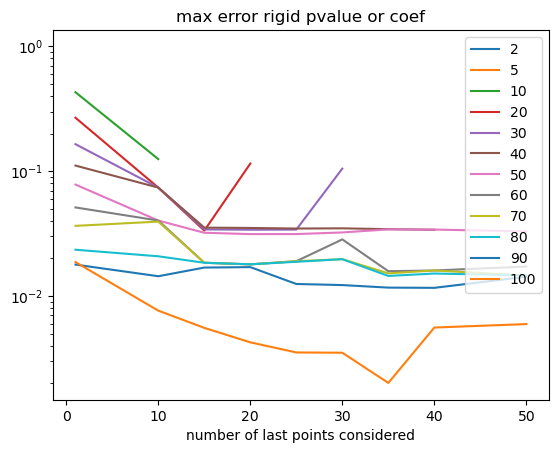

In [43]:
pv = pd.pivot_table(err_df, values = "maxerr_R2_or_coef_rigid", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("max error rigid pvalue or coef")

Text(0.5, 1.0, 'med error rigid pvalue or coef')

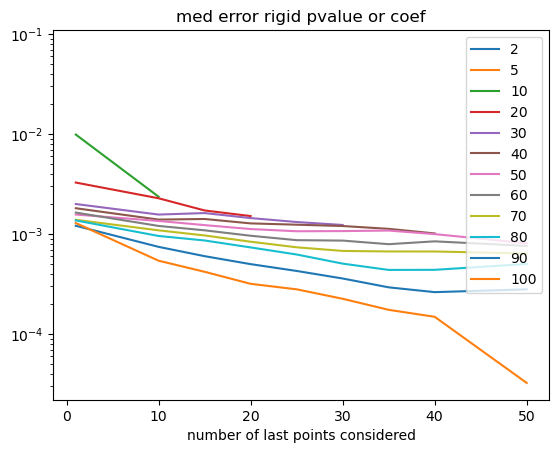

In [45]:
pv = pd.pivot_table(err_df, values = "mederr_R2_or_coef_rigid", index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("med error rigid pvalue or coef")

In [331]:
start_from_beg = True

In [332]:

import itertools
from itertools import permutations

df2 = df_w1000.iloc[include_].reset_index()

if start_from_beg:
    start_from = 0
    start_from_beg = False

# err_fs = np.zeros(len(min_points_range))
# err_fs2 = np.zeros(len(min_points_range))

# maxerr_fs = np.zeros(len(min_points_range))
# maxerr_fs2 = np.zeros(len(min_points_range))

err_fs3 = []
maxerr_fs3 = []
mederr_fs3 = []
fins_f_fs3 = []

if start_from_beg:
    err_df['fins_R2_rigid'] = np.full(len(err_df), np.nan)
    for i in range(0,8):
        col = 'tr' + str(i)
        err_df[col + '_success'] = np.full(len(err_df), np.nan)
        err_df[col + '_qs_sumerr'] = np.full(len(err_df), np.nan)
        err_df[col + '_qs_maxerr'] = np.full(len(err_df), np.nan)
        err_df[col + '_qs_mederr'] = np.full(len(err_df), np.nan)

for i, pars in err_df.iterrows():
    if not start_from_beg:
        if start_from > i:
            continue

    min_points = int(pars.min_points)
    last_point = int(pars.last_point)
    
    if i%10 == 0:
        print("Finished " + str(float(i) / len(err_df) * 100))
    
    if min_points < last_point:
        continue


    ms_f = np.zeros(len(df2.index))
    # ss_f = np.zeros(len(df2.index))
    # begs_f = np.zeros(len(df2.index))
    fins_f = np.zeros(len(df2.index))
    
    ms_f2 = np.zeros(len(df2.index))
    # ss_f2 = np.zeros(len(df2.index))
    # begs_f2 = np.zeros(len(df2.index))
    # fins_f2 = np.zeros(len(df2.index))

    for ind, row in df2.iterrows():
        q = row.q
        psb = row.p
        ps = row.ps
        
        m, s, beg, fin = get_quasilevel_rigid_first_ending(row.rho, last_point, 
                                                     min_points=min_points, 
                                                     condition="R2")
        ms_f[ind] = m
        # ss_f[ind] = s
        # begs_f[ind] = beg
        fins_f[ind] = fin
        if np.isnan(m):
            # print(row)
            # 0/0
            print((min_points, last_point, ind))
        
        # for triad in range(0,8):
        #     col = 'tr' + str(triad)
            
        #     m, s, beg, fin = get_quasilevel_rigid(row[col][0:fin], last_point, 
        #                                              condition="")
        #     ms_f2[ind] = m
    df2["fins_R2_rigid"] = fins_f
    
    err = (ms_f - df2_slash_1000.rho_qs_m) / df2_slash_1000.rho_qs_m
    err_fs3.append(np.sum(err**2))
    maxerr_fs3.append(np.max(np.abs(err)))
    mederr_fs3.append(np.median(np.abs(err)))
    fins_f_fs3.append(np.mean(fins_f))
    
    err_df.at[i, 'fins_R2_rigid'] = np.mean(fins_f)
    
    for triad in range(0,8):
        col = 'tr' + str(triad)
        for ind, row in df2.iterrows():
            q = row.q
            psb = row.p
            ps = row.ps
            
            fin = row["fins_R2_rigid"]
            if not np.isnan(fin):
                fin = int(fin)
                
                m, s, beg, fin = get_quasilevel_rigid(row[col][:fin], last_point, 
                                                        condition="")
            else:
                m = np.nan
            ms_f[ind] = m
            # ss_f[ind] = s
            # begs_f[ind] = beg
            # fins_f[ind] = fin
            
        err = (ms_f - df2_slash_1000[col + "_qs_m"]) / df2_slash_1000[col + "_qs_m"]
        # err_fs3.append(np.sum(err**2))
        # maxerr_fs3.append(np.max(np.abs(err)))
        # mederr_fs3.append(np.median(np.abs(err)))
        
        err_df.at[i, col + '_success'] = not any(np.isnan(err))
        err_df.at[i, col + '_qs_sumerr'] = np.sum(err**2)
        err_df.at[i, col + '_qs_maxerr'] = np.max(np.abs(err))
        err_df.at[i, col + '_qs_mederr'] = np.median(np.abs(err))
        
        
    start_from = i

# err_df['sumerr_R2_rigid'] = err_fs3
# err_df['maxerr_R2_rigid'] = maxerr_fs3
# err_df['fins_R2_rigid'] = fins_f_fs3


Finished 0.0
Finished 9.00900900900901
Finished 18.01801801801802
(300, 250, 1)
(300, 250, 2)
(300, 250, 4)
(300, 250, 5)
(300, 250, 6)
(300, 250, 9)
(300, 300, 1)
(300, 300, 2)
(300, 300, 3)
(300, 300, 4)
(300, 300, 5)
(300, 300, 6)
(300, 300, 7)
(300, 300, 8)
(300, 300, 9)
(300, 300, 18)
Finished 27.027027027027028
(400, 250, 1)
(400, 250, 2)
(400, 250, 4)
(400, 250, 5)
(400, 250, 6)
(400, 250, 9)
(400, 300, 1)
(400, 300, 2)
(400, 300, 3)
(400, 300, 4)
(400, 300, 5)
(400, 300, 6)
(400, 300, 7)
(400, 300, 8)
(400, 300, 9)
(400, 300, 18)
(400, 350, 0)
(400, 350, 1)
(400, 350, 2)
(400, 350, 3)
(400, 350, 4)
(400, 350, 5)
(400, 350, 6)
(400, 350, 7)
(400, 350, 8)
(400, 350, 9)
(400, 350, 14)
(400, 350, 16)
(400, 350, 18)
(400, 350, 19)
(400, 350, 20)
(400, 350, 22)
(400, 400, 0)
(400, 400, 1)
(400, 400, 2)
(400, 400, 3)
(400, 400, 4)
(400, 400, 5)
(400, 400, 6)
(400, 400, 7)
(400, 400, 8)
(400, 400, 9)
(400, 400, 11)
(400, 400, 12)
(400, 400, 14)
(400, 400, 16)
(400, 400, 18)
(400, 400, 

In [333]:
path = Path('stop_analysis2_err_df.h5')

err_df.to_hdf(path, key = 'err_df')

/home/pgorski/.local/lib/python3.8/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->boolean,key->block2_values] [items->Index(['tr0_success', 'tr1_success', 'tr2_success', 'tr3_success',
       'tr4_success', 'tr5_success', 'tr6_success', 'tr7_success'],
      dtype='object')]

  pytables.to_hdf(


In [ ]:
df2_slash_1000[col + "_qs_m"]

0     0.066128
1     0.067014
2     0.066470
3     0.066081
4     0.066040
        ...   
85    0.978465
86    0.977618
87    0.977382
88    0.976956
89    0.976124
Name: tr7_qs_m, Length: 90, dtype: float64

/tmp/ipykernel_13571/1355872723.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0, 0.5, '$\\sin (\\theta)$')

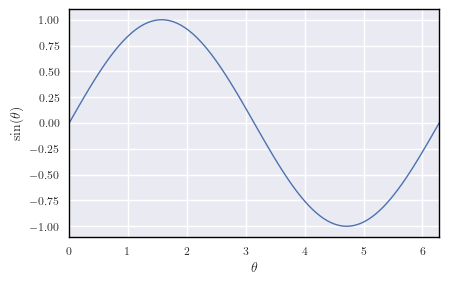

In [13]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

import numpy as np
import matplotlib.pyplot as plt

# Using seaborn's style
plt.style.use('seaborn')
width = 345
# width = 1000

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams.update(tex_fonts)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4

x = np.linspace(0, 2*np.pi, 100)
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
ax.plot(x, np.sin(x))
ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\sin (\theta)$')



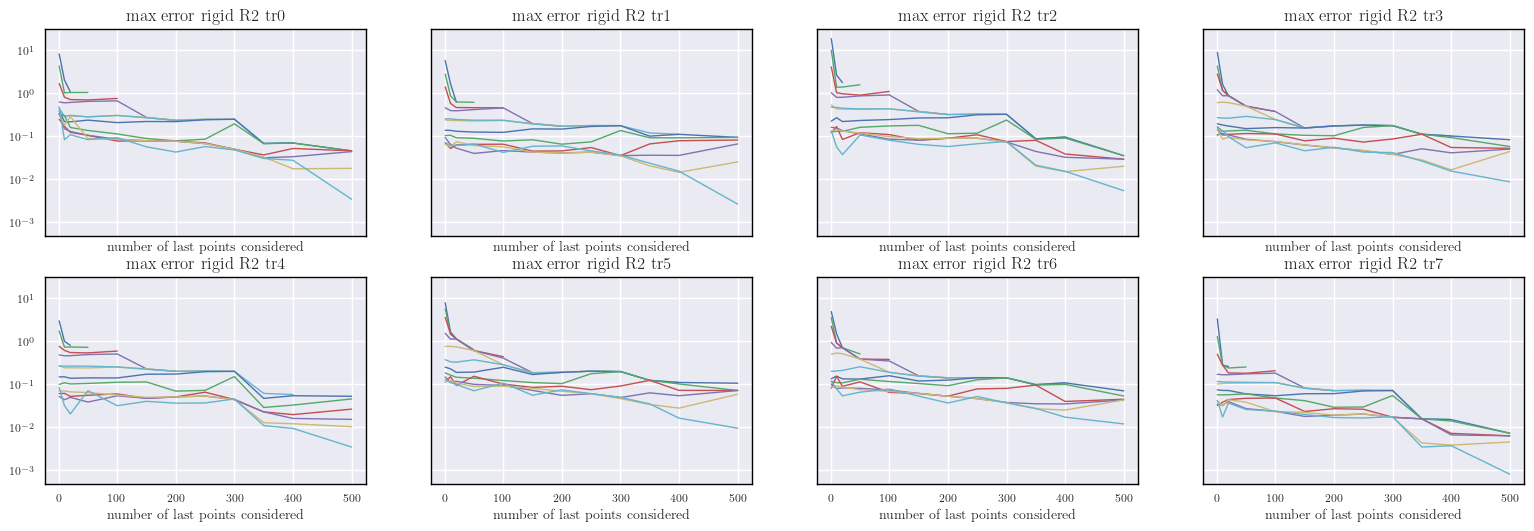

In [335]:
figsize = set_size(width)
figsize = (figsize[0]*4, figsize[1]*2)

fig, axs = plt.subplots(2, 4, figsize=figsize, sharey=True, sharex = True)

for triad in range(0,8):
    ax = axs.flat[triad]
    col = 'tr' + str(triad)
    
    pv = pd.pivot_table(err_df, values = col + "_qs_maxerr", index = "last_point", columns = "min_points")

    # ax = pv.plot(xticks=pv.index, ylabel='Murder Rate')
    ax.plot(pv)
    ax.set_xlabel("number of last points considered")
    # ax.legend(pv.columns)
    ax.set_yscale('log')
    ax.set_title("max error rigid R2 " + col)
    
    # break

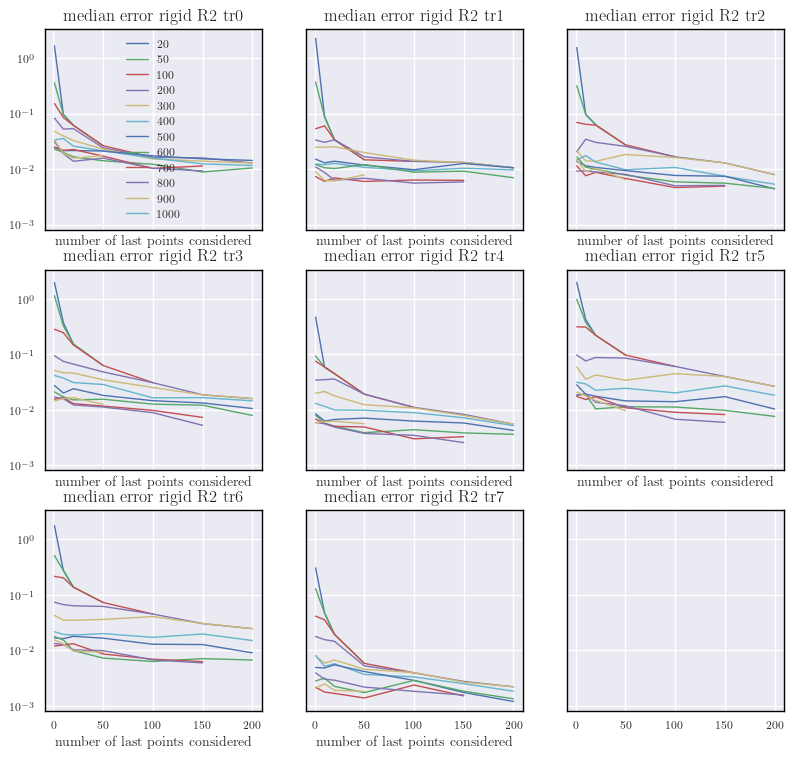

In [341]:
figsize = set_size(width)
figsize = (figsize[0]*2, figsize[1]*3)

fig, axs = plt.subplots(3, 3, figsize=figsize, sharey=True, sharex = True)

for triad in range(0,8):
    ax = axs.flat[triad]
    col = 'tr' + str(triad)
    
    pv = pd.pivot_table(err_df, values = col + "_qs_mederr", index = "last_point", columns = "min_points")

    # ax = pv.plot(xticks=pv.index, ylabel='Murder Rate')
    ax.plot(pv)
    ax.set_xlabel("number of last points considered")
    if triad == 0:
        ax.legend(pv.columns)
    ax.set_yscale('log')
    ax.set_title("median error rigid R2 " + col)
    
    # break

TODO: sprawdzic powyzsze rysunki, gdyby fin bylo brane dla odpowiedniej triady

In [337]:

import itertools
from itertools import permutations

df2 = df_slash_1000

col = "tr2"

min_points_range = [20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
last_points = [1, *list(range(10,400,20))]

# err_fs = np.zeros(len(min_points_range))
# err_fs2 = np.zeros(len(min_points_range))

# maxerr_fs = np.zeros(len(min_points_range))
# maxerr_fs2 = np.zeros(len(min_points_range))


err_fs3 = []
maxerr_fs3 = []
mederr_fs3 = []
fins_f_fs3 = []

for i, pars in err_df.iterrows():
    min_points = int(pars.min_points)
    last_point = int(pars.last_point)
    
    if i%10 == 0:
        print("Finished " + str(float(i) / len(err_df) * 100))
    
    if min_points < last_point:
        continue


    ms_f = np.zeros(len(df2.index))
    ss_f = np.zeros(len(df2.index))
    begs_f = np.zeros(len(df2.index))
    fins_f = np.zeros(len(df2.index))
    
    ms_f2 = np.zeros(len(df2.index))
    ss_f2 = np.zeros(len(df2.index))
    begs_f2 = np.zeros(len(df2.index))
    fins_f2 = np.zeros(len(df2.index))

    for ind, row in df2.iterrows():
        q = row.q
        psb = row.p
        ps = row.ps
        
        m, s, beg, fin = get_quasilevel_rigid_first_ending(row[col], last_point, 
                                                     min_points=min_points, 
                                                     condition="pvalue")
        ms_f[ind] = m
        ss_f[ind] = s
        begs_f[ind] = beg
        fins_f[ind] = fin
        
    err = (ms_f - df2_slash_1000[col + "_qs_m"]) / df2_slash_1000[col + "_qs_m"]
    err_fs3.append(np.sum(err**2))
    maxerr_fs3.append(np.max(np.abs(err)))
    mederr_fs3.append(np.median(np.abs(err)))
    fins_f_fs3.append(np.mean(fins_f))

err_df['sumerr_pv_rigid_' + col] = err_fs3
err_df['maxerr_pv_rigid_' + col] = maxerr_fs3
err_df['mederr_pv_rigid_' + col] = mederr_fs3
err_df['fins_pv_rigid_' + col] = fins_f_fs3
    


Finished 0.0


/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest on

Finished 9.00900900900901


/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest on

Finished 18.01801801801802


/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest on

Finished 27.027027027027028
Finished 36.03603603603604


/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/pgorski/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest on

KeyboardInterrupt: 

## Testing R2 or coef. How does triad accuracy change?

In [440]:
start_from_beg = True

In [441]:

import itertools
from itertools import permutations

df2 = df_w1000.iloc[include_].reset_index()

if start_from_beg:
    start_from = 0
    start_from_beg = False
    
    err_fs3 = np.full(len(err_df), np.nan)
    maxerr_fs3 = np.full(len(err_df), np.nan)
    mederr_fs3 = np.full(len(err_df), np.nan)
    fins_f_fs3 = np.full(len(err_df), np.nan)
    
    for i in range(0,8):
        col = 'tr' + str(i)
        err_df[col + 'R2_or_coef_success'] = np.full(len(err_df), False)
        err_df[col + 'R2_or_coef_qs_sumerr'] = np.full(len(err_df), np.nan)
        err_df[col + 'R2_or_coef_qs_maxerr'] = np.full(len(err_df), np.nan)
        err_df[col + 'R2_or_coef_qs_mederr'] = np.full(len(err_df), np.nan)
    

for i, pars in err_df.iterrows():
    if not start_from_beg:
        if start_from > i:
            continue

    min_points = int(pars.min_points)
    last_point = int(pars.last_point)
    
    if i%10 == 0:
        print("Finished " + str(float(i) / len(err_df) * 100))
    
    if min_points < last_point:
        continue


    ms_f = np.zeros(len(df2.index))
    # ss_f = np.zeros(len(df2.index))
    # begs_f = np.zeros(len(df2.index))
    fins_f = np.zeros(len(df2.index))
    
    ms_f2 = np.zeros(len(df2.index))
    # ss_f2 = np.zeros(len(df2.index))
    # begs_f2 = np.zeros(len(df2.index))
    # fins_f2 = np.zeros(len(df2.index))

    for ind, row in df2.iterrows():
        q = row.q
        psb = row.p
        ps = row.ps
        
        m, s, beg, fin = get_quasilevel_rigid_first_ending(row.rho, last_point, 
                                                     min_points=min_points, 
                                                     condition="R2_or_coef")
        ms_f[ind] = m
        # ss_f[ind] = s
        # begs_f[ind] = beg
        fins_f[ind] = fin
        if np.isnan(m):
            # print(row)
            # 0/0
            print((min_points, last_point, ind))
        
        # for triad in range(0,8):
        #     col = 'tr' + str(triad)
            
        #     m, s, beg, fin = get_quasilevel_rigid(row[col][0:fin], last_point, 
        #                                              condition="")
        #     ms_f2[ind] = m
    df2["fins_R2_rigid"] = fins_f
    
    # err = (ms_f - df2_slash_1000.rho_qs_m) / df2_slash_1000.rho_qs_m
    # err_fs3.append(np.sum(err**2))
    # maxerr_fs3.append(np.max(np.abs(err)))
    # mederr_fs3.append(np.median(np.abs(err)))
    # fins_f_fs3.append(np.mean(fins_f))
    
    for triad in range(0,8):
        col = 'tr' + str(triad)
        for ind, row in df2.iterrows():
            q = row.q
            psb = row.p
            ps = row.ps
            
            fin = row["fins_R2_rigid"]
            if not np.isnan(fin):
                fin = int(fin)
                
                m, s, beg, fin = get_quasilevel_rigid(row[col][:fin], last_point, 
                                                        condition="")
            else:
                m = np.nan
            ms_f[ind] = m
            # ss_f[ind] = s
            # begs_f[ind] = beg
            # fins_f[ind] = fin
            
        err = (ms_f - df2_slash_1000[col + "_qs_m"]) / df2_slash_1000[col + "_qs_m"]
        # err_fs3.append(np.sum(err**2))
        # maxerr_fs3.append(np.max(np.abs(err)))
        # mederr_fs3.append(np.median(np.abs(err)))
        
        err_df.at[i, col + 'R2_or_coef_success'] = not any(np.isnan(err))
        err_df.at[i, col + 'R2_or_coef_qs_sumerr'] = np.sum(err**2)
        err_df.at[i, col + 'R2_or_coef_qs_maxerr'] = np.max(np.abs(err))
        err_df.at[i, col + 'R2_or_coef_qs_mederr'] = np.median(np.abs(err))
        
        
    start_from = i

# err_df['sumerr_R2_rigid'] = err_fs3
# err_df['maxerr_R2_rigid'] = maxerr_fs3
# err_df['fins_R2_rigid'] = fins_f_fs3


Finished 0.0
Finished 9.00900900900901
Finished 18.01801801801802
Finished 27.027027027027028
(400, 350, 4)
(400, 350, 5)
(400, 350, 8)
(400, 350, 14)
(400, 350, 18)
(400, 400, 2)
(400, 400, 3)
(400, 400, 4)
(400, 400, 5)
(400, 400, 8)
(400, 400, 14)
(400, 400, 16)
(400, 400, 18)
(400, 400, 19)
Finished 36.03603603603604
(500, 350, 4)
(500, 350, 5)
(500, 350, 8)
(500, 350, 14)
(500, 350, 18)
(500, 400, 2)
(500, 400, 3)
(500, 400, 4)
(500, 400, 5)
(500, 400, 8)
(500, 400, 14)
(500, 400, 16)
(500, 400, 18)
(500, 400, 19)
Finished 45.04504504504504
(500, 500, 2)
(500, 500, 3)
(500, 500, 4)
(500, 500, 5)
(500, 500, 6)
(500, 500, 8)
(500, 500, 9)
(500, 500, 14)
(500, 500, 16)
(500, 500, 18)
(500, 500, 19)
Finished 54.054054054054056
(600, 350, 4)
(600, 350, 5)
(600, 350, 8)
(600, 350, 14)
(600, 350, 18)
(600, 400, 2)
(600, 400, 3)
(600, 400, 4)
(600, 400, 5)
(600, 400, 8)
(600, 400, 14)
(600, 400, 16)
(600, 400, 18)
(600, 400, 19)
(600, 500, 2)
(600, 500, 3)
(600, 500, 4)
(600, 500, 5)
(600

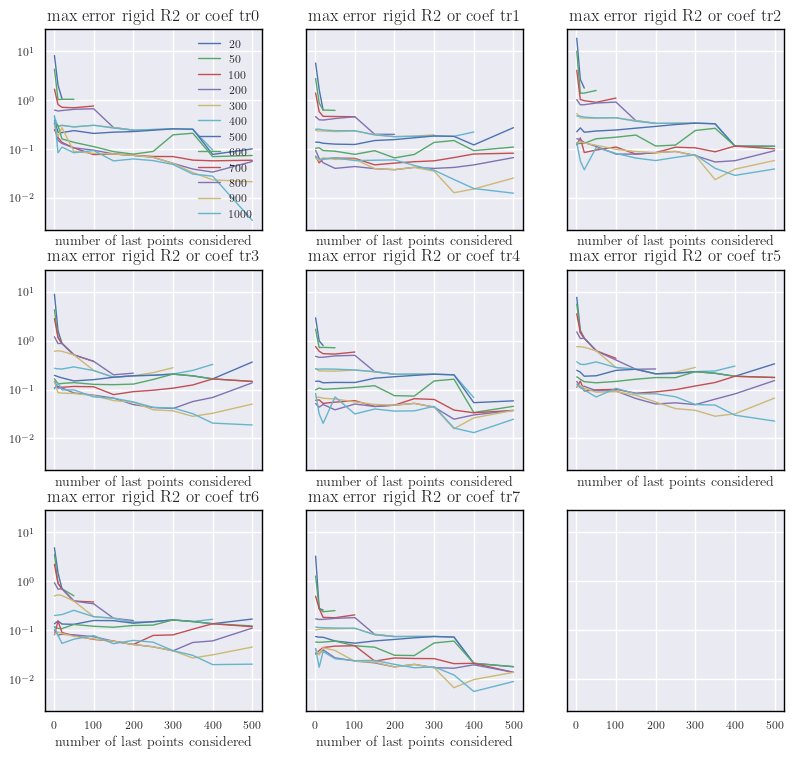

In [442]:
figsize = set_size(width)
figsize = (figsize[0]*2, figsize[1]*3)

fig, axs = plt.subplots(3, 3, figsize=figsize, sharey=True, sharex = True)

for triad in range(0,8):
    ax = axs.flat[triad]
    col = 'tr' + str(triad)
    
    pv = pd.pivot_table(err_df, values = col + "R2_or_coef_qs_maxerr", index = "last_point", columns = "min_points")

    # ax = pv.plot(xticks=pv.index, ylabel='Murder Rate')
    ax.plot(pv)
    ax.set_xlabel("number of last points considered")
    if triad == 0:
        ax.legend(pv.columns)
    ax.set_yscale('log')
    ax.set_title("max error rigid R2 or coef " + col)
    
    # break

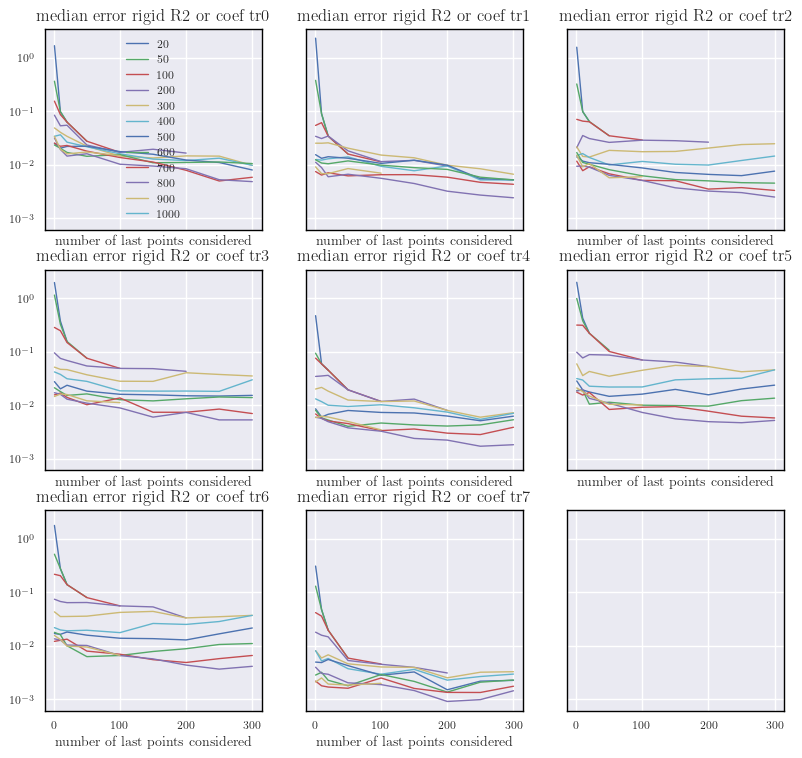

In [443]:
figsize = set_size(width)
figsize = (figsize[0]*2, figsize[1]*3)

fig, axs = plt.subplots(3, 3, figsize=figsize, sharey=True, sharex = True)

for triad in range(0,8):
    ax = axs.flat[triad]
    col = 'tr' + str(triad)
    
    pv = pd.pivot_table(err_df, values = col + "R2_or_coef_qs_mederr", index = "last_point", columns = "min_points")

    # ax = pv.plot(xticks=pv.index, ylabel='Murder Rate')
    ax.plot(pv)
    ax.set_xlabel("number of last points considered")
    if triad == 0:
        ax.legend(pv.columns)
    ax.set_yscale('log')
    ax.set_title("median error rigid R2 or coef " + col)
    
    # break

In [ ]:
from sklearn.linear_model import LinearRegression

beg = 1000-180
fin = 1000

fit = LinearRegression()
X = list(range(beg, fin))
y = list(df2.iloc[28].rho[beg:fin])
fit.fit(X, y)
fit.coef_, fit.score(X, y)
# df2.iloc[15].rho[beg:fin]
# np.array(list(range(beg, fin))

ValueError: Expected 2D array, got 1D array instead:
array=[820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837
 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855
 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873
 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909
 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927
 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945
 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963
 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981
 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
from sklearn.linear_model import LinearRegression

beg = 1000-180
fin = 1000

fit = LinearRegression()
X = list(range(beg, fin))
y = list(df2.iloc[28].rho[beg:fin])
fit.fit(X, y)
fit.coef_, fit.score(X, y)
# df2.iloc[15].rho[beg:fin]
# np.array(list(range(beg, fin))

ValueError: Expected 2D array, got 1D array instead:
array=[820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837
 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855
 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873
 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909
 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927
 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945
 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963
 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981
 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
from sklearn.linear_model import LinearRegression

beg = 1000-180
fin = 1000

fit = LinearRegression()
X = list(range(beg, fin))
y = list(df2.iloc[28].rho[beg:fin])
fit.fit(X, y)
fit.coef_, fit.score(X, y)
# df2.iloc[15].rho[beg:fin]
# np.array(list(range(beg, fin))

ValueError: Expected 2D array, got 1D array instead:
array=[820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837
 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855
 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873
 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909
 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927
 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945
 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963
 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981
 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Text(0.5, 1.0, 'sum error rigid R2 tr2')

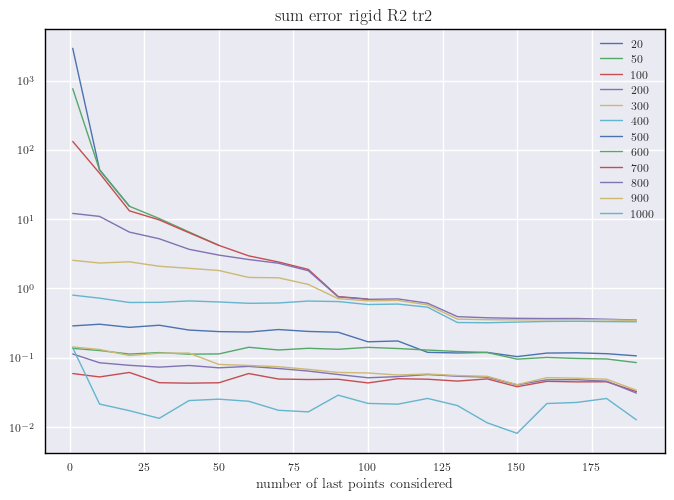

In [ ]:
pv = pd.pivot_table(err_df, values = "sumerr_R2_rigid_" + col, index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("sum error rigid R2 " + col)

Text(0.5, 1.0, 'max error rigid R2 tr2')

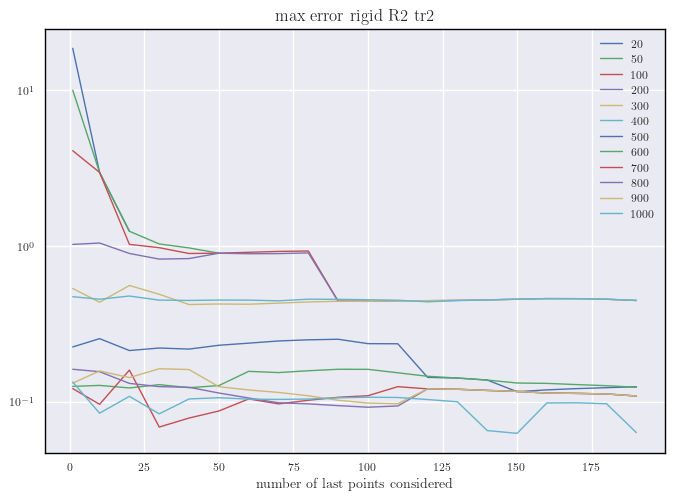

In [ ]:
pv = pd.pivot_table(err_df, values = "maxerr_R2_rigid_" + col, index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("max error rigid R2 " + col)

Text(0.5, 1.0, 'med error rigid R2 tr2')

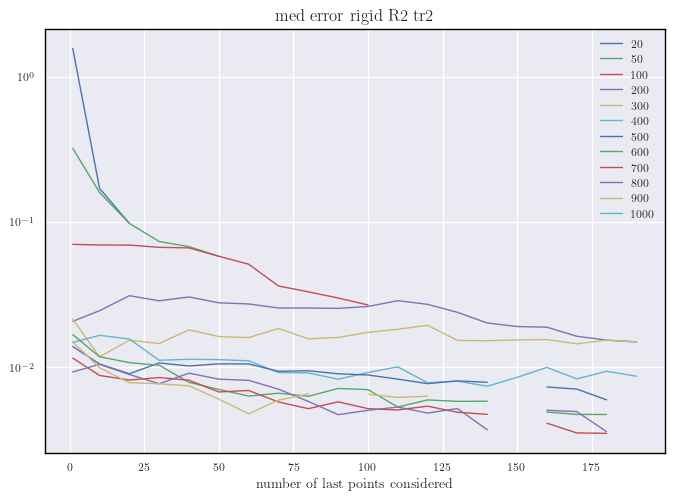

In [ ]:
pv = pd.pivot_table(err_df, values = "mederr_R2_rigid_" + col, index = "last_point", columns = "min_points")

plt.plot(pv)
plt.xlabel("number of last points considered")
plt.legend(pv.columns)
plt.yscale('log')
plt.title("med error rigid R2 " + col)

In [ ]:
col = "tr0"
min_points = 300
last_point = 100

ms_f = np.zeros(len(df2.index))
ss_f = np.zeros(len(df2.index))
begs_f = np.zeros(len(df2.index))
fins_f = np.zeros(len(df2.index))

ms_f2 = np.zeros(len(df2.index))
ss_f2 = np.zeros(len(df2.index))
begs_f2 = np.zeros(len(df2.index))
fins_f2 = np.zeros(len(df2.index))

for ind, row in df2.iterrows():
    q = row.q
    psb = row.p
    ps = row.ps
    
    m, s, beg, fin = get_quasilevel_rigid_first_ending(row[col], last_point, 
                                                    min_points=min_points, 
                                                    condition="R2")
    ms_f[ind] = m
    ss_f[ind] = s
    begs_f[ind] = beg
    fins_f[ind] = fin

In [ ]:
err = (ms_f - df2_slash_1000[col + "_qs_m"]) / df2_slash_1000[col + "_qs_m"]
np.median(np.abs(err))

0.02105612604643927

Text(0.5, 1.0, 'q,psbt,pst = 0.9,0.0,0.5')

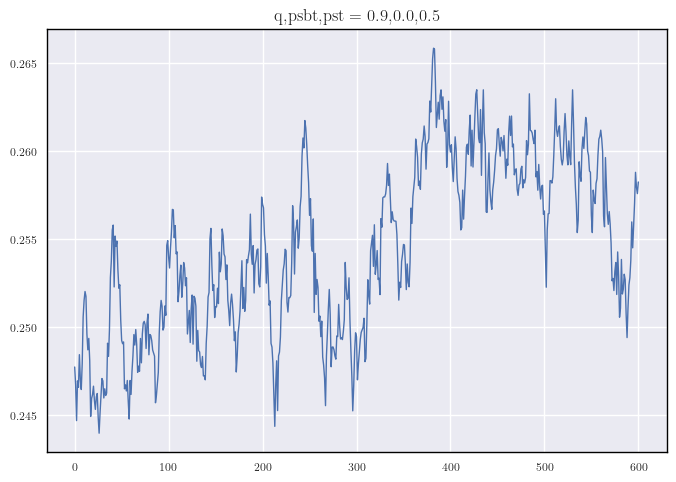

In [316]:
ind = 0

plt.plot(df_slash_1000.iloc[ind][col][400:])
plt.title("q,psbt,pst = " + str(df_slash_1000.iloc[ind].q) + "," + str(df_slash_1000.iloc[ind].p) + "," + str(df_slash_1000.iloc[ind].ps) )

In [ ]:
(q, p, ps) = df2_slash_1000.iloc[ind][["q", "p", "ps"]].values
df2_slash_1000.iloc[ind][["tr0_qs_m", "tr0_qs_s", "tr0_qs_b", "tr0_qs_f"]]

tr0_qs_m    0.255518
tr0_qs_s    0.004479
tr0_qs_b       500.0
tr0_qs_f      1001.0
Name: 0, dtype: object

In [ ]:
df2_slash_1000_g = group_quasilevels(df2_slash_1000)
df2_slash_1000_g.loc[(q, p,ps)]
# ind

/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


q                  0.900000
p                  0.000000
ps                 0.500000
repetitions       10.000000
rho_lvl            0.445116
rho_lvl_std        0.000606
rho_lvl_valid     10.000000
rho_lvl2                NaN
rho_lvl2_std            NaN
rho_lvl2_valid     0.000000
rho_lvl_exp        0.366025
tr_valid          10.000000
tr0_lvl            0.254473
tr0_lvl_std        0.001329
tr1_lvl            0.159249
tr1_lvl_std        0.000333
tr2_lvl            0.111611
tr2_lvl_std        0.000333
tr3_lvl            0.081719
tr3_lvl_std        0.000450
tr4_lvl            0.166236
tr4_lvl_std        0.000280
tr5_lvl            0.068505
tr5_lvl_std        0.000319
tr6_lvl            0.091753
tr6_lvl_std        0.000433
tr7_lvl            0.066419
tr7_lvl_std        0.000447
Name: (0.9, 0.0, 0.5), dtype: float64

In [ ]:
df2_slash_1000_g

q    p   ps  repetitions   rho_lvl  rho_lvl_std  rho_lvl_valid  \
0.5 0.0 0.5  0.5  0.0  0.5           10  0.413184     0.000476             10   
        1.0  0.5  0.0  1.0           10  0.510883     0.000586             10   
    0.8 0.5  0.5  0.8  0.5           10  0.869073     0.002749             10   
        1.0  0.5  0.8  1.0           10  0.935291     0.000604             10   
    1.0 0.5  0.5  1.0  0.5           10  0.925995     0.001206             10   
        1.0  0.5  1.0  1.0           10  0.947938     0.000544             10   
0.9 0.0 0.5  0.9  0.0  0.5           10  0.445116     0.000606             10   
    0.8 0.5  0.9  0.8  0.5           10  0.805224     0.003369             10   
    1.0 0.5  0.9  1.0  0.5           10  0.908187     0.001293             10   

             rho_lvl2  rho_lvl2_std  rho_lvl2_valid  ...   tr3_lvl  \
0.5 0.0 0.5       NaN           NaN               0  ...  0.076546   
        1.0       NaN           NaN               0  ...  0.113096   
    0.8 0.5  0.869073      0.002749              10  ...  0.036470   
        1.0  0.935291      0.000604              10  ...  0.005172   
    1.0 0.5  0.925995      0.001206              10  ...  0.007800   
        1.0  0.947938      0.000544              10  ...  0.002943   
0.9 0.0 0.5       NaN           NaN               0  ...  0.081719   
    0.8 0.5  0.805224      0.003369              10  ...  0.090649   
    1.0 0.5  0.908187      0.001293              10  ...  0.019227   

             tr3_lvl_std   tr4_lvl  tr4_lvl_std   tr5_lvl  tr5_lvl_std  \
0.5 0.0 0.5     0.000142  0.166141     0.000146  0.077188     0.000126   
        1.0     0.000253  0.140760     0.000321  0.110346     0.000208   
    0.8 0.5     0.001497  0.013271     0.000419  0.033257     0.001581   
        1.0     0.000194  0.007103     0.000126  0.005841     0.000275   
    1.0 0.5     0.000331  0.007785     0.000193  0.008256     0.000369   
        1.0     0.000122  0.006066     0.000094  0.003859     0.000210   
0.9 0.0 0.5     0.000450  0.166236     0.000280  0.068505     0.000319   
    0.8 0.5     0.003597  0.021102     0.000923  0.061984     0.002448   
    1.0 0.5     0.000988  0.007065     0.000143  0.011352     0.000723   

              tr6_lvl  tr6_lvl_std   tr7_lvl  tr7_lvl_std  
0.5 0.0 0.5  0.080417     0.000161  0.050666     0.000122  
        1.0  0.119890     0.000251  0.125718     0.000682  
    0.8 0.5  0.037883     0.001856  0.863124     0.005948  
        1.0  0.010085     0.000345  0.968727     0.000880  
    1.0 0.5  0.012008     0.000453  0.959663     0.001372  
        1.0  0.008127     0.000353  0.977556     0.000689  
0.9 0.0 0.5  0.091753     0.000433  0.066419     0.000447  
    0.8 0.5  0.082190     0.002728  0.697088     0.014195  
    1.0 0.5  0.019677     0.001015  0.933916     0.003109  

[9 rows x 28 columns]

In [ ]:
get_quasilevel_rigid_first_ending(df.iloc[ind].tr0, ini_beg = last_point, min_points=min_points, condition="R2")

(0.13387785267038438, 0.002045951779777293, 200, 300)

In [ ]:
beg = 249
fin = beg + 100

fit = LinearRegression()
X = np.array(list(range(beg, fin))).reshape(-1, 1)
y = df2.iloc[ind].tr0[beg:fin].reshape(-1, 1)
fit.fit(X, y)
fit.coef_, fit.score(X, y)

(array([[2.51320569e-05]]), 0.09472432297231881)

In [ ]:
get_quasilevel_rigid(df2.iloc[ind].tr0[0:fin], ini_beg=last_point, condition="R2")

(nan, nan, nan, nan)

In [ ]:
rho_ = df2.iloc[ind].tr0[0:fin]
condition = "R2"
ini_beg = last_point
m, s, beg, fin = get_quasilevel_rigid(rho_, ini_beg=ini_beg, condition=condition)
np.isnan(m)

True

In [422]:
rho = df2.iloc[ind].rho

for cur_fin in range(min_points, len(rho)):
    rho_ = rho[0:cur_fin]
    
    m, s, beg, fin = get_quasilevel_rigid(rho_, ini_beg=ini_beg, condition=condition)
    if not np.isnan(m):
        print("fin")
        break


fin


In [396]:
m, s, beg, fin = get_quasilevel_rigid_first_ending(rho, ini_beg = last_point, min_points=min_points, condition="R2")
m, s, beg, fin

(0.4439966830758507, 0.0009260251900018322, 696, 996)

In [397]:
m, s, beg, fin = get_quasilevel_rigid_first_ending(rho, ini_beg = 200, min_points=min_points, conditions=["R2", "variance", "pvalue"])
m, s, beg, fin

(0.44395551976645864, 0.0008631718862504484, 715, 915)

In [398]:
m, s, beg, fin = get_quasilevel_rigid_first_ending(rho, ini_beg = 300, min_points=300, conditions=[ "pvalue"])
m, s, beg, fin

(nan, nan, nan, nan)

In [424]:
m, s, beg, fin = get_quasilevel_rigid_first_ending(rho, ini_beg = 300, min_points=300, conditions=[ "pvalue_or_coef"])
m, s, beg, fin

(0.4445724430970902, 0.00127824076109434, 627, 927)

In [423]:
m, s, beg, fin = get_quasilevel_rigid_first_ending(rho, ini_beg = 300, min_points=300, conditions=[ "R2_or_coef"])
m, s, beg, fin

(0.4445724430970902, 0.00127824076109434, 627, 927)

In [315]:
m, s, beg, fin = get_quasilevel_rigid_first_ending(rho, ini_beg = 300, min_points=300, conditions = ["R2", "variance"])# conditions=["R2", "variance", "pvalue"])
m, s, beg, fin

(0.25099599150641344, 0.003372317750176385, 405, 705)

In [343]:
rho[beg], m - s

(0.2496363600055914, 0.24900907753519802)

In [400]:
beg = 393
fin = beg + 300

X = np.array(list(range(beg, fin))).reshape(-1, 1)
y = df2.iloc[ind].rho[beg:fin].reshape(-1, 1)
mod = sm.OLS(y, sm.add_constant(X))
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
p_values

const    0.000000e+00
x1       2.357759e-98
Name: P>|t|, dtype: float64

In [401]:
fii.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.774     
Dependent Variable: y                AIC:                -3377.6519
Date:               2023-07-07 11:24 BIC:                -3370.2443
No. Observations:   300              Log-Likelihood:     1690.8    
Df Model:           1                F-statistic:        1023.     
Df Residuals:       298              Prob (F-statistic): 2.36e-98  
R-squared:          0.774            Scale:              7.4987e-07
---------------------------------------------------------------------
           Coef.    Std.Err.       t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      0.4580     0.0003   1444.0666   0.0000    0.4574    0.4586
x1        -0.0000     0.0000    -31.9814   0.0000   -0.0000   -0.0000
-------------------------------------------------------------------
Omnibus:               6.302         Durbin-Watson:           0.331
Prob(Omnibus):         0.043         Jarque-Bera (JB):        6.421
Skew:                  -0.337        Prob(JB):                0.040
Kurtosis:              2.759         Condition No.:           3485 
===================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
[2] The condition number is large, 3.48e+03. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

In [404]:
np.abs(fii.params[1]) < 0.00001

False

In [375]:
fit = LinearRegression()
X = np.array(list(range(beg, fin))).reshape(-1, 1)
y = rho[beg:fin].reshape(-1, 1)
fit.fit(X, y)
fit.coef_

array([[-4.22420588e-06]])

In [276]:
ind = 97
last_point = 20
min_points = last_point

rho = df2.iloc[ind].rho

pvs = np.zeros(len(rho) - min_points)
coefs = np.zeros(len(rho) - min_points)

R2s = np.zeros(len(rho) - min_points)

for i, cur_fin in enumerate(range(min_points, len(rho))):
    
    beg = cur_fin - last_point
    rho_ = rho[beg:cur_fin]
    
    X = np.array(list(range(beg, cur_fin))).reshape(-1, 1)
    y = rho_.reshape(-1, 1)
    mod = sm.OLS(y, sm.add_constant(X))
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    # p_values
    
    pvs[i] = p_values.x1
    coefs[i] = fii.params[1]
    
    fit = LinearRegression()
    # X = np.array(list(range(beg, cur_fin))).reshape(-1, 1)
    # y = rho[beg:fin].reshape(-1, 1)
    fit.fit(X, y)
    R2s[i] = fit.score(X, y)
 

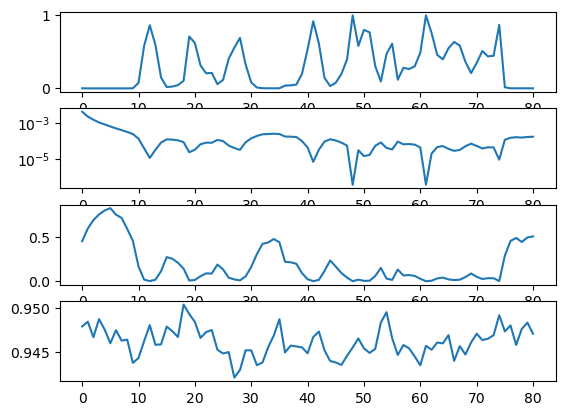

In [277]:
fig, axs = plt.subplots(4,1)

axs[0].plot(pvs)
axs[1].plot(np.abs(coefs))
axs[1].set_yscale('log')
axs[2].plot(np.abs(R2s))
axs[3].plot(rho[20:])
# plt.yscale('log')

In [258]:
np.min(R2s)

8.409578028079068e-05

In [245]:

get_quasilevel_rigid_first_ending(rho, last_point, 
                                    min_points=min_points, 
                                    condition="R2")

(0.9061527871195562, 0.003008730478973567, 21, 41)

In [233]:
# df2.iloc[ind]
last_point, min_points

(20, 100)